In [1]:
import numpy as np
import pandas as pd
import scanpy
import anndata as ad

import seaborn as sns; sns.set(color_codes=True); sns.set_style("whitegrid"); 
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

import networkx as nx
from scipy.spatial import Delaunay
import copy

In [5]:
adata = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/pca_stage2_samples/p135_e9_adtumorV5_TV.h5ad')
adata

AnnData object with n_obs × n_vars = 1757421 × 39
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'remove', 'case_split', 'KEEP', 'LOSE', 'MART1class', 'MART1pos', 'phenotypev2', 'imageid_rename', 'contiguous_spatial', 'case', 'simplified_phenotype', 'geomx_aoi', 'phenotype_all', 'geomx_aoi_cluster_ID', 'morphology', 'combined_hist', 'recurrence'
    uns: 'all_markers'
    layers: 'log'

In [3]:
adata.obs.simplified_phenotype.unique()

['SOX9-NGFR+', 'SOX9-NGFR-MART1-', 'SOX9-NGFR-MART1+', 'SOX9+NGFR-MART1+', 'SOX9+NGFR-MART1-', 'SOX9+NGFR+', 'SOX10-SOX9+']
Categories (7, object): ['SOX9-NGFR+', 'SOX9-NGFR-MART1-', 'SOX9-NGFR-MART1+', 'SOX9+NGFR-MART1+', 'SOX9+NGFR-MART1-', 'SOX9+NGFR+', 'SOX10-SOX9+']

In [5]:
adata.obs.phenotypev2.unique()

['SOX10+SOX9-NGFR+', 'SOX10+SOX9-NGFR-MART1-', 'SOX10+SOX9-NGFR-MART1+', 'SOX10+SOX9+NGFR-MART1+', 'SOX10+SOX9+NGFR-MART1-', 'SOX10+SOX9+NGFR+', 'SOX10-SOX9+']
Categories (7, object): ['SOX10+SOX9-NGFR+', 'SOX10+SOX9-NGFR-MART1-', 'SOX10+SOX9-NGFR-MART1+', 'SOX10+SOX9+NGFR-MART1+', 'SOX10+SOX9+NGFR-MART1-', 'SOX10+SOX9+NGFR+', 'SOX10-SOX9+']

In [8]:
adata.obs.imageid.value_counts()

LSP15192      395382
LSP15129      386373
LSP13078      195251
LSP13186      152263
LSP15156      150588
LSP15210      117755
LSP13179      113798
LSP15219_a     66053
LSP15183       49993
LSP15120       43214
LSP15219_b     26588
LSP13102       21478
LSP15138       21405
LSP15201       17280
Name: imageid, dtype: int64

In [9]:
adata.obs.contiguous_spatial

LSP13102--unmicst_cellRing_65117-0-0      LSP13102_1
LSP13102--unmicst_cellRing_65123-0-0      LSP13102_1
LSP13102--unmicst_cellRing_65159-0-0      LSP13102_1
LSP13102--unmicst_cellRing_65197-0-0      LSP13102_1
LSP13102--unmicst_cellRing_65289-0-0      LSP13102_1
                                             ...    
LSP15192--unmicst_cellRing_1133260-0-1    LSP15192_1
LSP15192--unmicst_cellRing_1135617-0-1    LSP15192_1
LSP15192--unmicst_cellRing_1136859-0-1    LSP15192_1
LSP15192--unmicst_cellRing_1136908-0-1    LSP15192_1
LSP15192--unmicst_cellRing_1136983-0-1    LSP15192_1
Name: contiguous_spatial, Length: 1757421, dtype: category
Categories (20, object): ['LSP13078_1', 'LSP13102_1', 'LSP13179_1', 'LSP13186_1', ..., 'LSP15219_a_2', 'LSP15219_b_1', 'LSP15219_b_2', 'Other']

In [13]:
# LSP15192 is the only sample that has a meaningful SOX10-SOX9+ population
adata[adata.obs.simplified_phenotype == 'SOX10-SOX9+'].obs.imageid.value_counts()

LSP15192    31440
Name: imageid, dtype: int64

In [53]:
adata

AnnData object with n_obs × n_vars = 1757421 × 39
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'remove', 'case_split', 'KEEP', 'LOSE', 'MART1class', 'MART1pos', 'phenotypev2', 'imageid_rename', 'contiguous_spatial', 'case', 'simplified_phenotype', 'geomx_aoi', 'phenotype_all', 'geomx_aoi_cluster_ID', 'morphology', 'combined_hist', 'recurrence'
    uns: 'all_markers'
    layers: 'log'

In [ ]:
### USE 7 classes for all samples when calculating spatial (check code) and nbhd (max_entropy) entropy. ### 
### look at average ECAD expression along the distance bands, maybe divided into 3 bands. Plot for each sample and if get a trend, combine for all samples and show together. ###
### GeoMX clusters - make heatmap across markers: already done, I think? ###

### Check patient samples

/Users/ediknovik/anaconda3/envs/spatialcells/lib/python3.9/site-packages/scanpy/plotting/_utils.py:429: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list


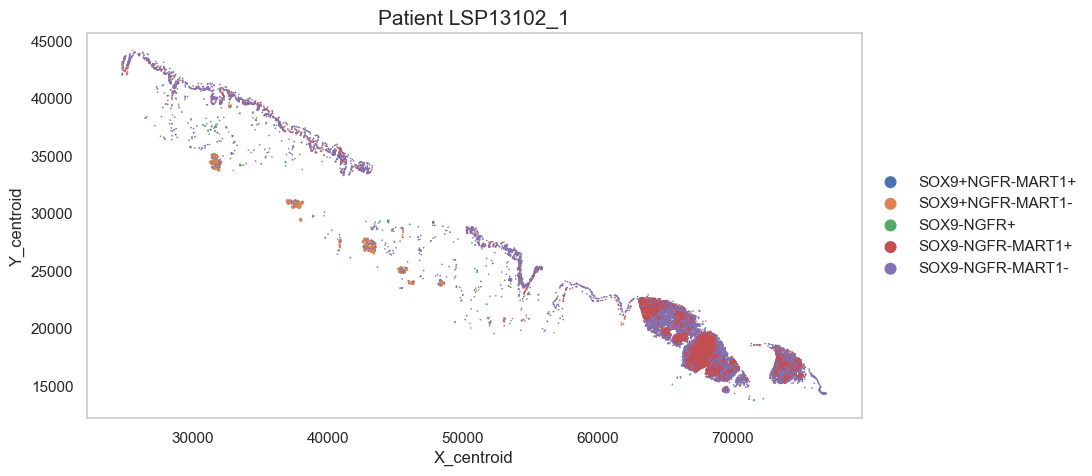

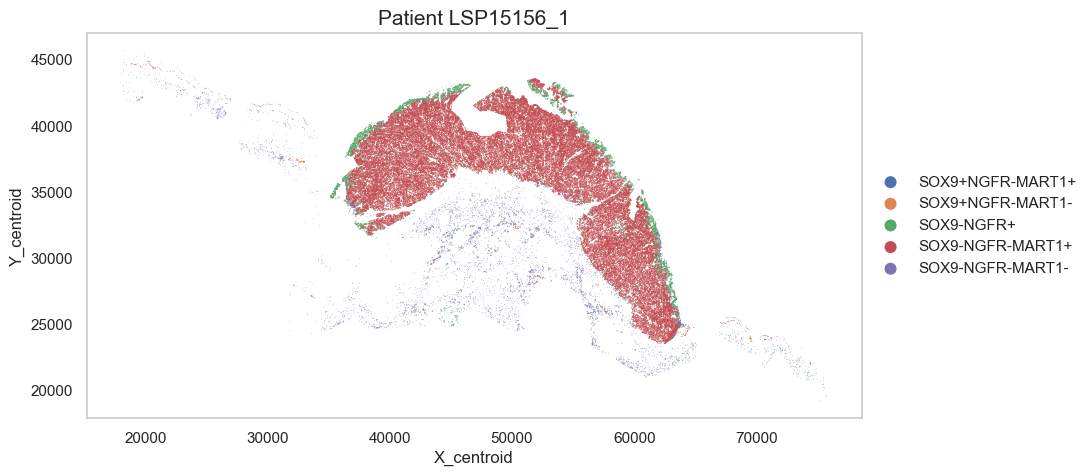

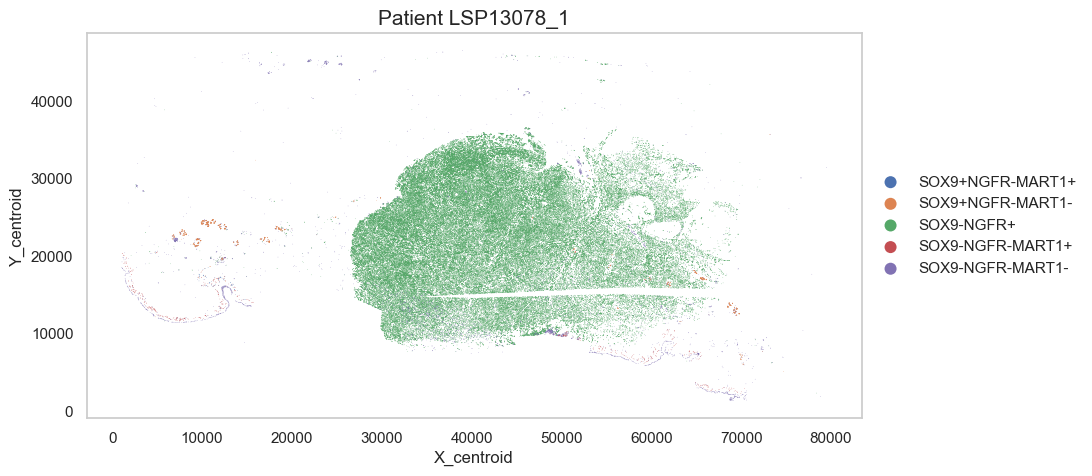

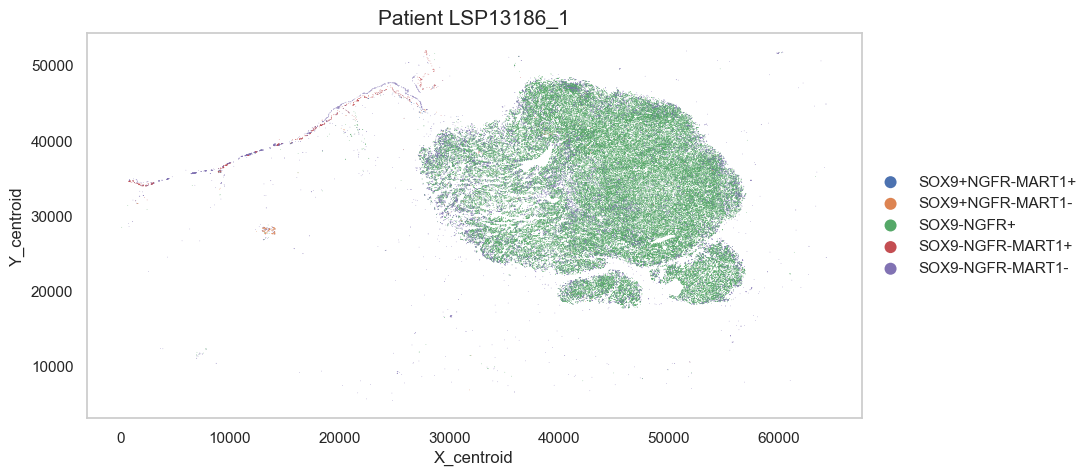

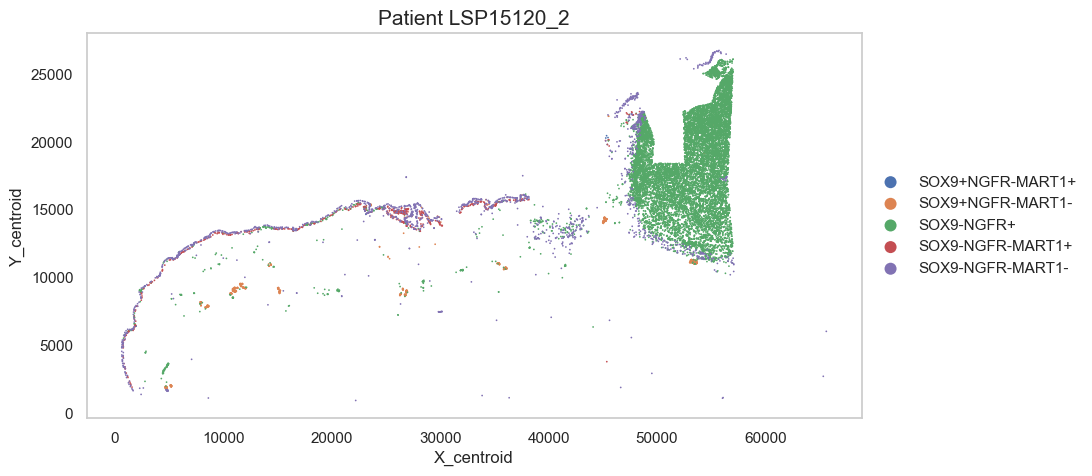

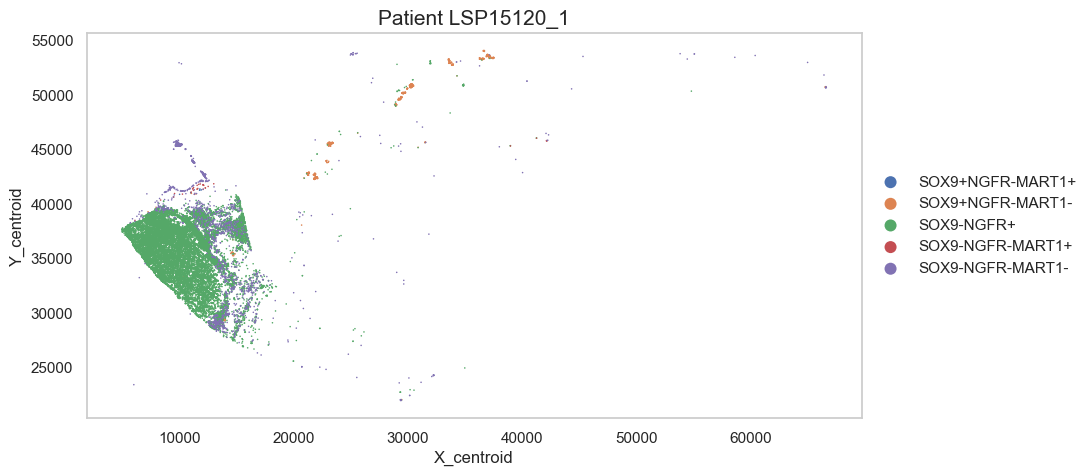

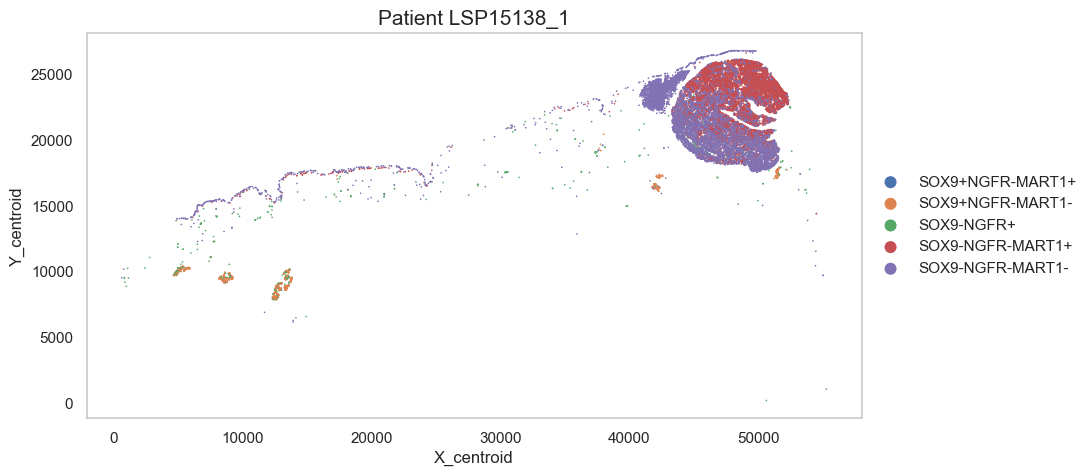

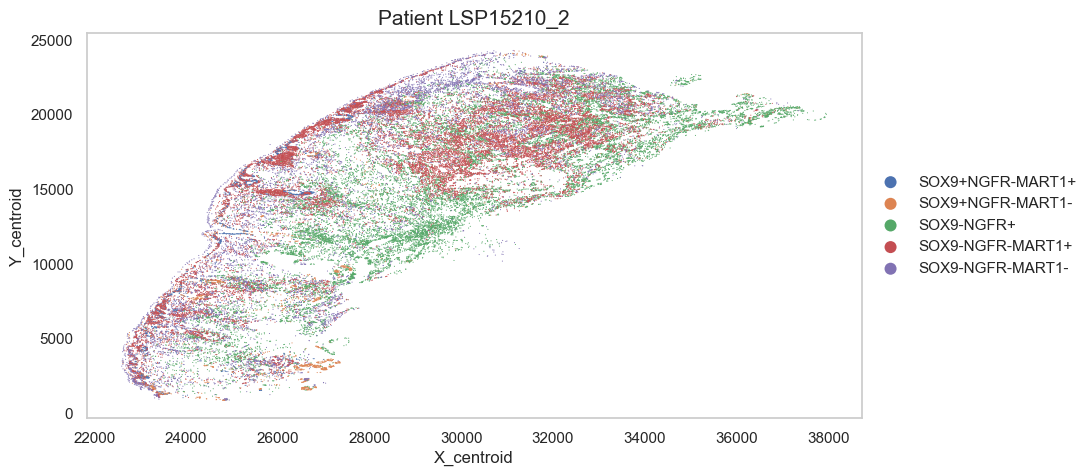

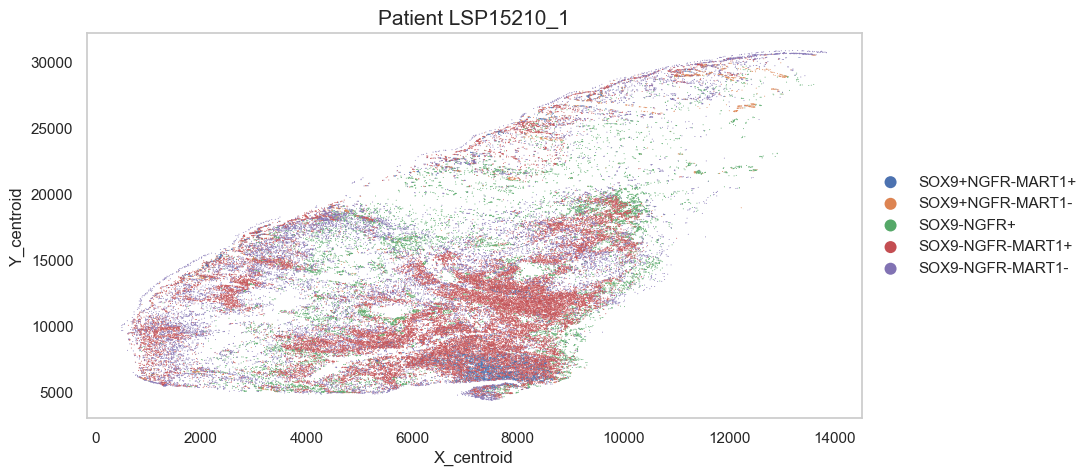

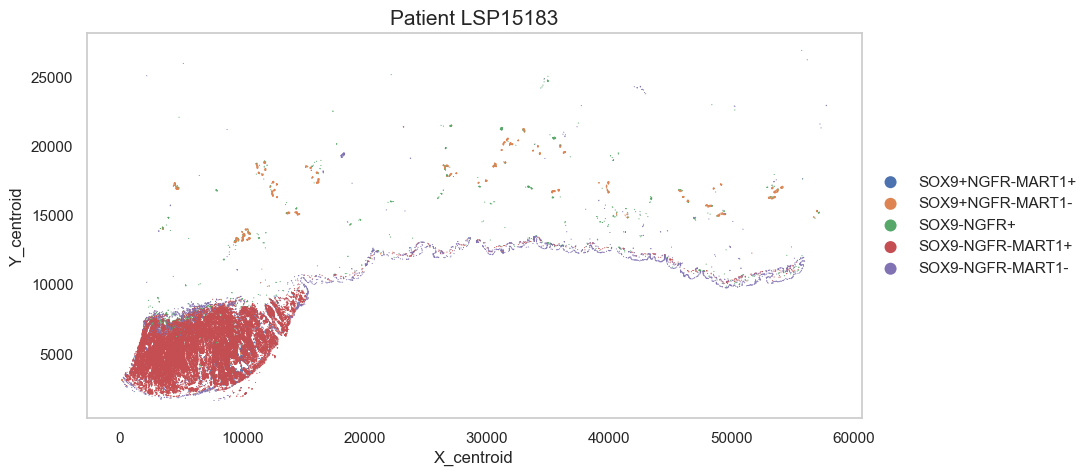

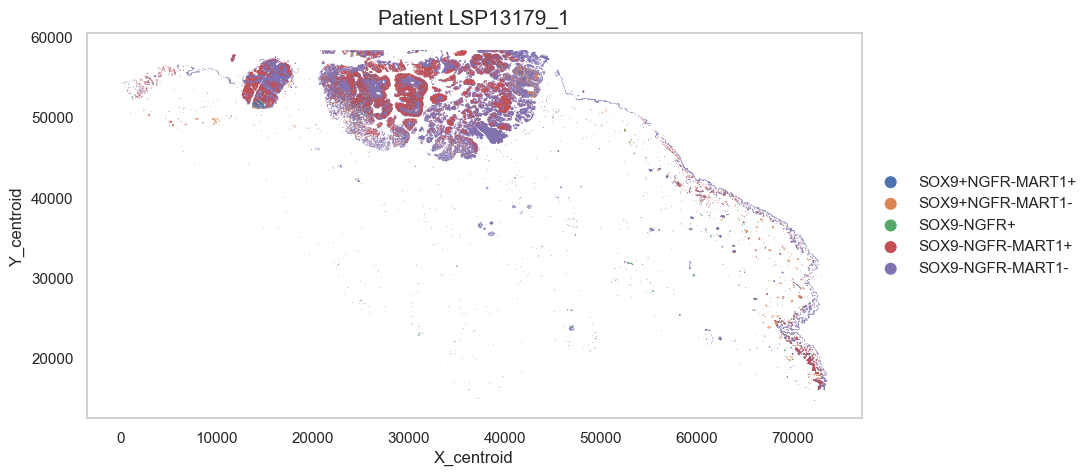

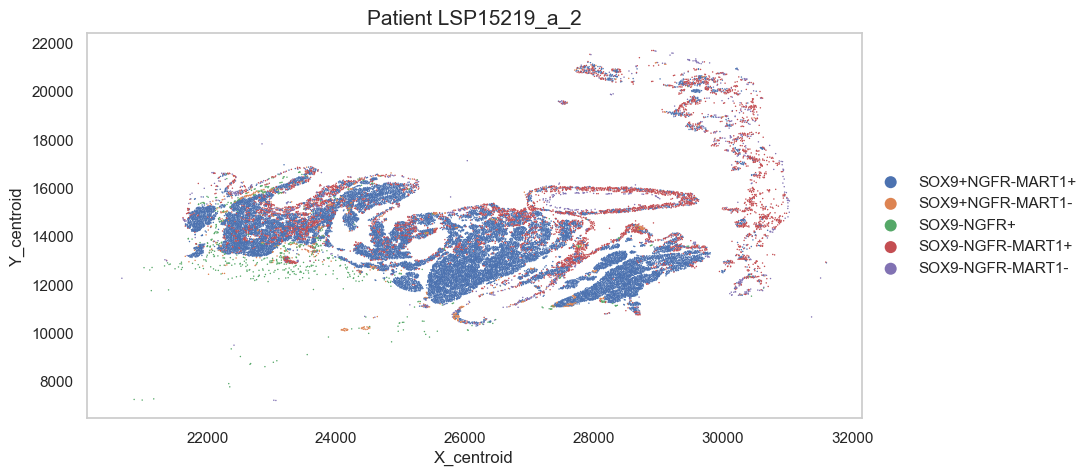

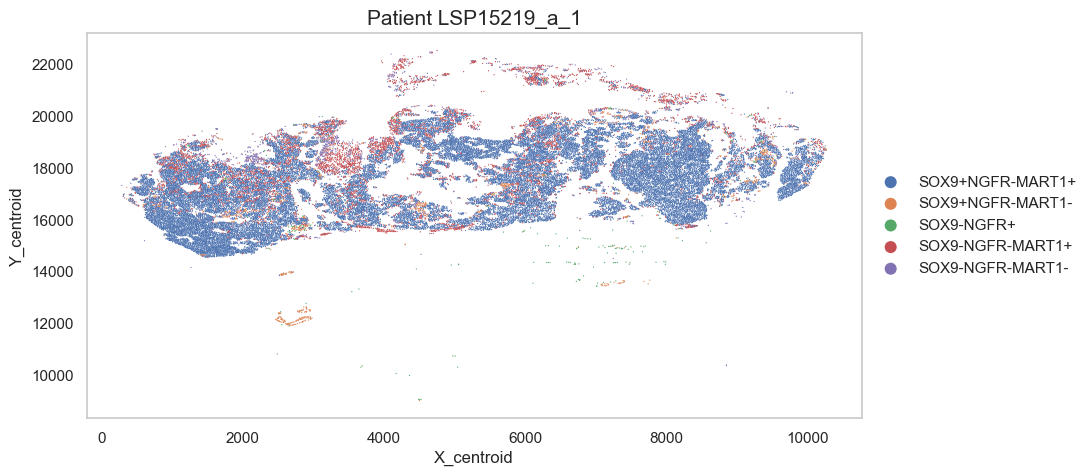

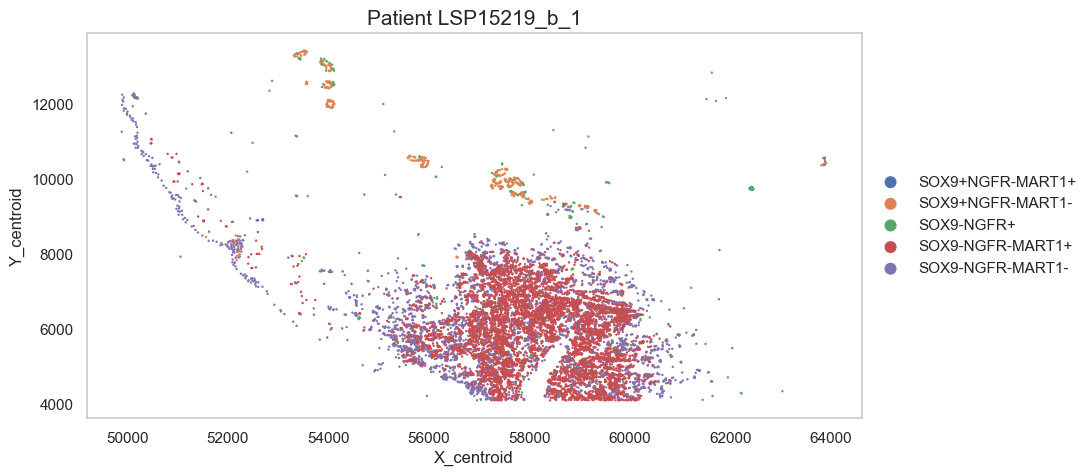

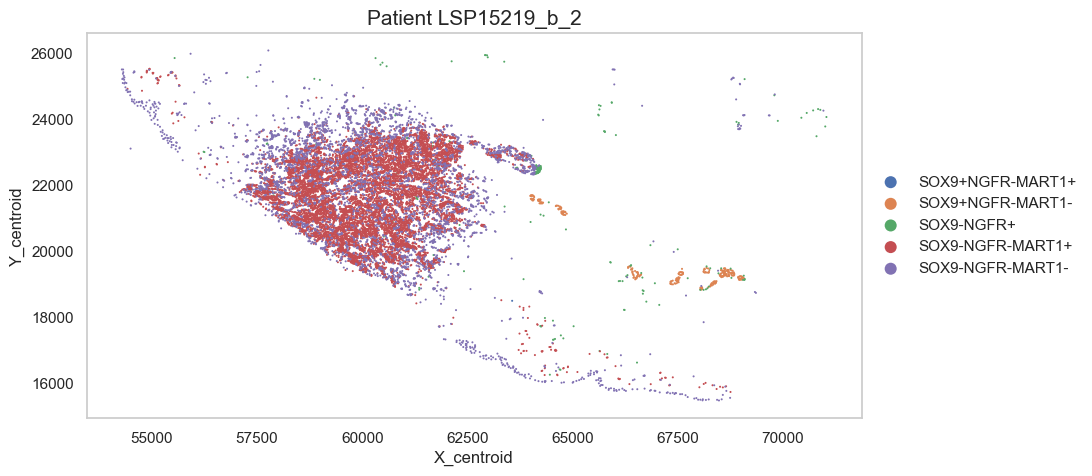

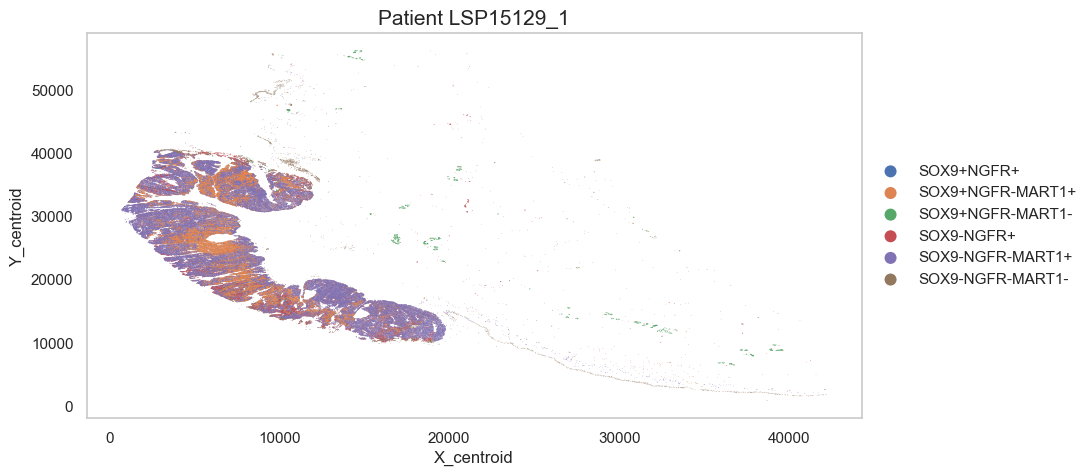

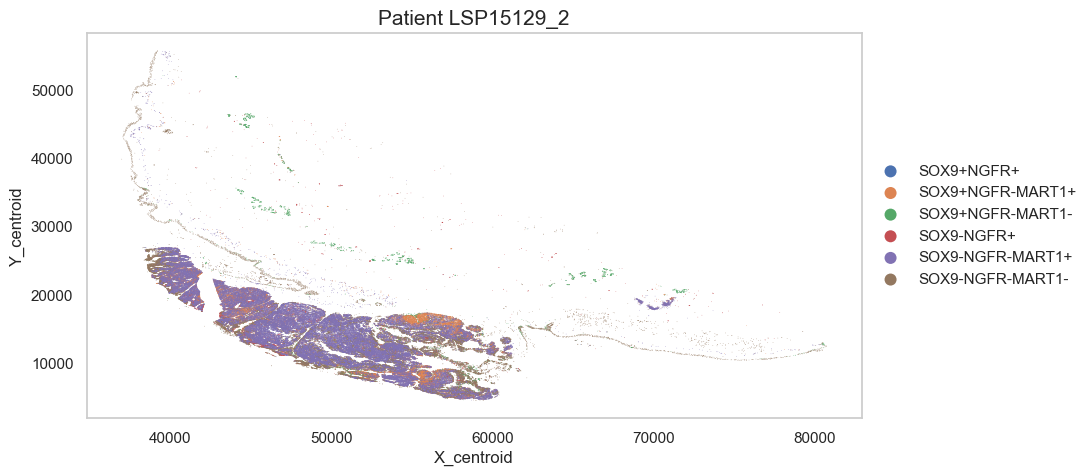

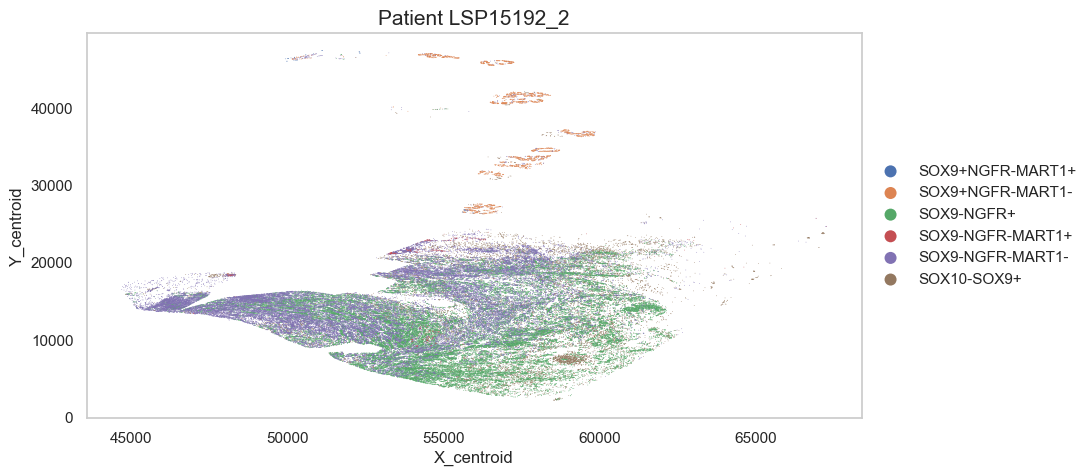

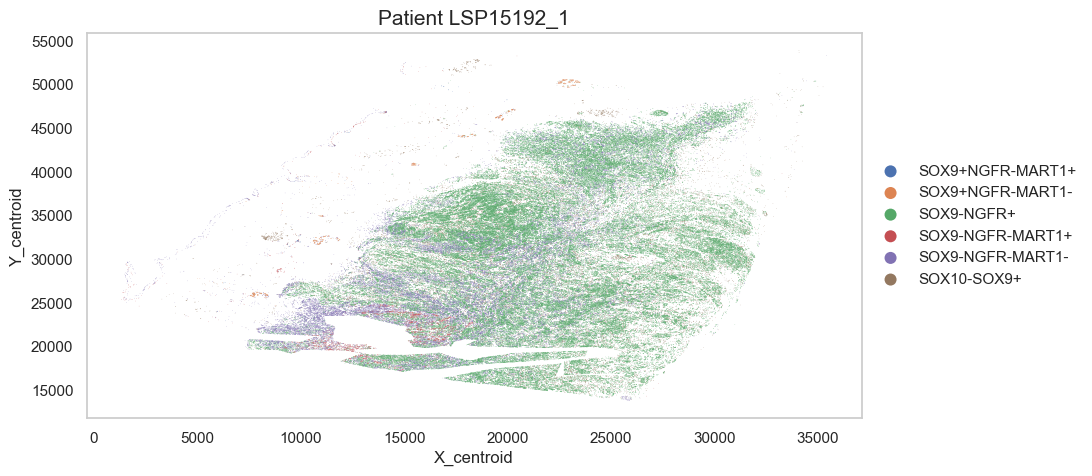

In [14]:
for patient in adata.obs.contiguous_spatial.unique():
    if patient in ['Other']:
        continue
    data = adata[adata.obs.contiguous_spatial == patient]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
    scanpy.pl.scatter(data,x='X_centroid',y='Y_centroid',color='simplified_phenotype', ax=ax, show=False)
    ax.set_title(f'Patient {patient}', fontsize=15)

## Perform Stage 2 entropy analysis

In [ ]:
### decide whether or  not to include ngfr+ population if want to do stage I vs stage II comparison 

In [2]:
def less_first(a, b):
    return [a,b] if a < b else [b,a]

def delaunay2edges(tri):

    list_of_edges = []

    for triangle in tri.simplices:
        for e1, e2 in [[0,1],[1,2],[2,0]]: # for all edges of triangle
            list_of_edges.append(less_first(triangle[e1],triangle[e2])) # always lesser index first

    array_of_edges = np.unique(list_of_edges, axis=0) # remove duplicates

    list_of_lengths = []

    for p1,p2 in array_of_edges:
        x1, y1 = tri.points[p1]
        x2, y2 = tri.points[p2]
        list_of_lengths.append((x1-x2)**2 + (y1-y2)**2)

    array_of_lengths = np.sqrt(np.array(list_of_lengths))

    return array_of_edges, array_of_lengths

In [3]:
def make_graph(df, node_attribute_name='lineage_grouped', plot_graph=False):
    coordinates = np.column_stack((df['X_centroid'], df['Y_centroid']))
    tri = Delaunay(coordinates)

    edges, lengths = delaunay2edges(tri)
    # pruning the graph can be done later - use full graph from Delaunay tri for now
    ''' 
    criterion = np.argwhere(lengths < 30).flatten() # can convert pixels to microns
    selected_edges = edges[criterion]
    print('Removed', len(edges) - len(selected_edges), 'edges')
    '''
    cellids = df['CellID'].reset_index(drop=True)
    
    # map cellids to nodes that connect edges
    for i, (ind1, ind2) in enumerate(edges):
        edges[i] = [cellids[ind1], cellids[ind2]]
    
    # create graph object
    G = nx.Graph()
    G.add_nodes_from(cellids)
    G.add_edges_from(edges) # G.add_edges_from(selected_edges)

    if plot_graph:
        nx.draw(G, with_labels=False, node_size=5, node_color='lightgreen')

    # add weights to graph edges
    for i, e in enumerate(G.edges()):
        G[e[0]][e[1]]['weight'] = lengths[i]

    lineages = df[node_attribute_name]
    lineages.index = df['CellID']
    # add attribute to each node
    nx.set_node_attributes(G, lineages, name=node_attribute_name)
    ### G.nodes[5510]['lineage2'] # example how to access node attribute

    graph_dict = nx.to_dict_of_dicts(G)

    # calculate average num nhbrs across cells
    num_nbhrs = []
    for k, v in graph_dict.items():
        num_nbhrs.append(len(v))
    print(f'Average number of neighbors per cell = {np.mean(num_nbhrs)}')

    return G, graph_dict

In [4]:
def calculate_spatial_entropy(df, G, graph_dict, node_attribute_name='lineage_grouped', base=None):
    lineage_list = df[node_attribute_name].unique().tolist() # E.g. # lineage_list = ['MART1+ MITF- SOX9+', 'MART1- MITF- SOX9-', 'MART1+ MITF- SOX9-', 'MART1+ MITF+ SOX9+', 'MART1+ MITF+ SOX9-', 'MART1- MITF+ SOX9+', 'MART1- MITF+ SOX9-', 'MART1- MITF- SOX9+']
    spatial_entropy_dict = dict.fromkeys(lineage_list)

    for i, lineage_name in enumerate(lineage_list):
        # nodes for class i
        # nodes_class_i = [x for x,y in G.nodes(data=True) if y[node_attribute_name]==lineage_list[i]] # will need unique lineage2 strings to loop through
        nodes_class_i = []
        for x, y in G.nodes(data=True):
            if str(y[node_attribute_name])==str(lineage_list[i]):
                nodes_class_i.append(x)
        # print(f'Number of nodes with lineage {lineage_name}  = {len(nodes_class_i)}')

        neighbor_i_dicts_list = [graph_dict[x] for x in nodes_class_i]
        compare_lineages = copy.deepcopy(lineage_list)
        del compare_lineages[i]

        L_ik = dict.fromkeys(compare_lineages, 0) # count of neighbors where lineage k != i
        d_ik = dict.fromkeys(compare_lineages, 0) # average distance between neighbors where lineage k != i
        for nhbrs_dict in neighbor_i_dicts_list:
            for cell, edge in nhbrs_dict.items():
                # access node attribute
                attribute = G.nodes[cell][node_attribute_name]
                if str(attribute) != str(lineage_list[i]):
                    L_ik[attribute] += 1
                    d_ik[attribute] += edge['weight']

        # for attribute, count in L_ik.items():
        #     if count != 0:
        #         d_ik[attribute] /= count

        L_i = sum(L_ik.values()) * 100 # scaling factor for vizualization
        # L_i /= G.number_of_edges()
        d_i = sum(d_ik.values())

        spatial_entropy_dict[lineage_name] = {'L_i': L_i, 'd_i': d_i}
    # print(spatial_entropy_dict)
    lineages = df[node_attribute_name]
    p = lineages.value_counts(normalize=True, sort=False) # proportion of lineage counts

    spatial_entropy_df = pd.DataFrame.from_dict(spatial_entropy_dict, orient='index')
    spatial_entropy_df['ratio_i'] = spatial_entropy_df['L_i'] / spatial_entropy_df['d_i']
    # print(spatial_entropy_df)
    w = pd.merge(spatial_entropy_df, p, how='inner', left_index=True, right_index=True)
    w = w.drop(columns=['L_i', 'd_i'])
    # print(w)
    base = 2 if base is None else base
    H_spatial = -(w['ratio_i'] * w[node_attribute_name] * np.log(w[node_attribute_name])/np.log(base)).sum()

    return H_spatial

### Function to aggregate spatial entropy across patients

In [18]:
def heterogeneity_per_sample(adata, node_attribute_name, sample_column_name='imageid'):
    data = adata.copy() # stage 2 samples contain all tumor cells by default

    sample_list = data.obs[sample_column_name].unique().tolist()
    H_spatial_dict = {}
    for sample in sample_list:
        print(sample)
        if sample == 'Other':
            continue
        df = data[data.obs[sample_column_name] == sample].obs
        G, graph_dict = make_graph(df, node_attribute_name=node_attribute_name)
        H_spatial = calculate_spatial_entropy(df, G, graph_dict, node_attribute_name=node_attribute_name)
        H_spatial_dict[sample] = H_spatial
    H_spatial_df = pd.DataFrame.from_dict(H_spatial_dict, orient='index').reset_index().rename(columns={'index': 'sample', 0:'H_spatial'}).sort_values(by='H_spatial', ascending=False)

    fig, ax = plt.subplots(figsize=(12,10))
    sns.scatterplot(x=H_spatial_df['sample'], y=H_spatial_df['H_spatial'], color='black', ax=ax)
    ax.set_title(f'Spatial heterogeneity of {node_attribute_name} across samples', fontsize=15)
    ax.set_xlabel('Sample ID')
    ax.set_ylabel('Spatial entropy')
    ax.tick_params(labelrotation=90)
    ax.xaxis.grid(True) # Show the vertical gridlines
    fig.tight_layout()
    plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/spatial_entropy/spatial_entropy_stage_2_{node_attribute_name}_across_samples.pdf", format="pdf", bbox_inches="tight")

LSP13102_1
Average number of neighbors per cell = 5.997112922002328
Other
LSP15156_1
Average number of neighbors per cell = 5.9997343745849605
LSP13078_1
Average number of neighbors per cell = 5.999682302181867
LSP13186_1
Average number of neighbors per cell = 5.999737217262198
LSP15120_2
Average number of neighbors per cell = 5.9964717480413015
LSP15120_1
Average number of neighbors per cell = 5.998657042135303
LSP15138_1
Average number of neighbors per cell = 5.9976640971735575
LSP15210_2
Average number of neighbors per cell = 5.998485789718901
LSP15210_1
Average number of neighbors per cell = 5.998641324859226
LSP15183
Average number of neighbors per cell = 5.998918594172424
LSP13179_1
Average number of neighbors per cell = 5.999410192608976
LSP15219_a_2
Average number of neighbors per cell = 5.998530546269424
LSP15219_a_1
Average number of neighbors per cell = 5.9989697890643106
LSP15219_b_1
Average number of neighbors per cell = 5.995647873392681
LSP15219_b_2
Average number of nei

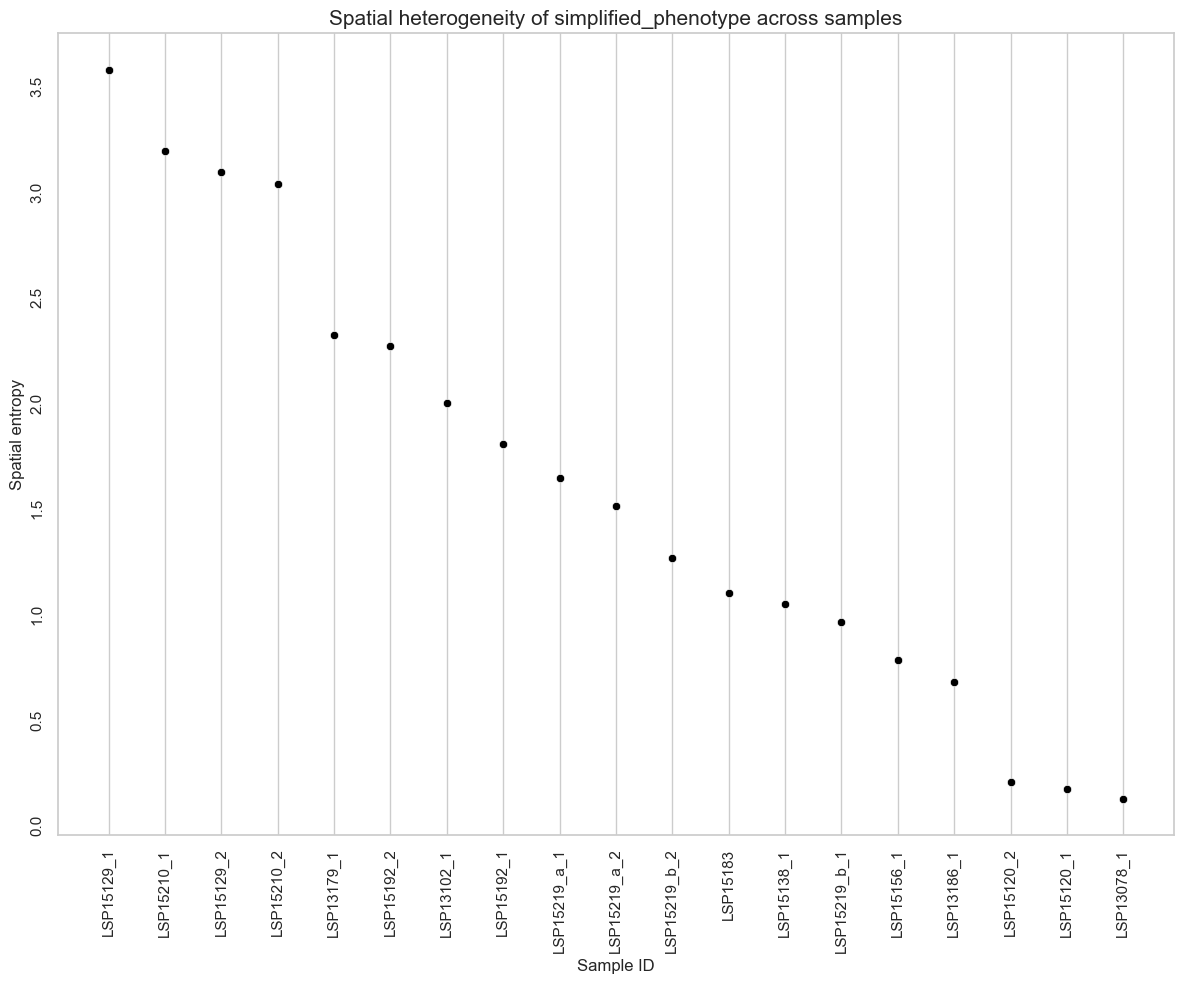

In [19]:
heterogeneity_per_sample(adata, node_attribute_name='simplified_phenotype', sample_column_name='contiguous_spatial')

In [29]:
# df1 = adata[adata.obs.contiguous_spatial == 'Other'].obs
# df1[df1['CellID'] == 39836]
# print(adata.obs.contiguous_spatial.unique().tolist()))

X_centroid    Y_centroid  Area  \
LSP15192--unmicst_cellRing_39836  61255.601407   6450.425557   853   
LSP15201--unmicst_cellRing_39836  46257.142132  10326.015228   591   

                                  MajorAxisLength  MinorAxisLength  \
LSP15192--unmicst_cellRing_39836        37.160261        29.253973   
LSP15201--unmicst_cellRing_39836        30.318328        25.138229   

                                  Eccentricity  Solidity    Extent  \
LSP15192--unmicst_cellRing_39836      0.616649  0.975973  0.764337   
LSP15201--unmicst_cellRing_39836      0.559037  0.957861  0.815172   

                                  Orientation  CellID  ...       KEEP   LOSE  \
LSP15192--unmicst_cellRing_39836     1.160697   39836  ...  undefined  Other   
LSP15201--unmicst_cellRing_39836     0.130661   39836  ...      Other  Other   

                                         phenotype       MART1class MART1pos  \
LSP15192--unmicst_cellRing_39836  SOX10+SOX9-NGFR+  failed_classify   MART1-   
LSP15201--unmicst_cellRing_39836  SOX10+SOX9-NGFR-  failed_classify   MART1-   

                                             phenotypev2 imageid_rename  \
LSP15192--unmicst_cellRing_39836        SOX10+SOX9-NGFR+       LSP15192   
LSP15201--unmicst_cellRing_39836  SOX10+SOX9-NGFR-MART1-       LSP15201   

                                 contiguous_spatial   case  \
LSP15192--unmicst_cellRing_39836              Other  MEL82   
LSP15201--unmicst_cellRing_39836              Other  MEL83   

                                 simplified_phenotype  
LSP15192--unmicst_cellRing_39836     SOX9-NGFR+MART1-  
LSP15201--unmicst_cellRing_39836     SOX10+SOX9-NGFR-  

[2 rows x 23 columns]

In [ ]:
def heterogeneity_by_GeoMX_regions(adata, node_attribute_name):
    data = adata.copy() # stage 2 samples contain all tumor cells by default
    data = data[data.obs.geomx_aoi != 'Other']

    geomx_roi_list = data.obs.geomx_aoi.unique().tolist()
    H_spatial_dict = {}
    for geomx_roi in geomx_roi_list:
        geomx_roi_df = data[data.obs.geomx_aoi == geomx_roi].obs
        print(f'GeoMX Region {geomx_roi} shape: {geomx_roi_df.shape}')
        if geomx_roi_df.shape[0] > 10:
            G, graph_dict = make_graph(geomx_roi_df, node_attribute_name=node_attribute_name)
            H_spatial = calculate_spatial_entropy(geomx_roi_df, G, graph_dict, node_attribute_name=node_attribute_name)
            H_spatial_dict[geomx_roi] = H_spatial
        else:
            print(f'Skipping GeoMX Region: {geomx_roi}')

    H_spatial_df = pd.DataFrame.from_dict(H_spatial_dict, orient='index').reset_index().rename(columns={'index': 'GeoMX_ROI', 0:'H_spatial'}).sort_values(by='H_spatial', ascending=False)

    fig, ax = plt.subplots(figsize=(24,20))
    sns.scatterplot(x=H_spatial_df['GeoMX_ROI'], y=H_spatial_df['H_spatial'], color='black', ax=ax)
    ax.set_title(f'Stage II: Regional entropy of {node_attribute_name} across GeoMX regions', fontsize=15)
    ax.set_xlabel('GeoMX Region ID')
    ax.set_ylabel('Regional entropy')
    ax.tick_params(labelrotation=90)
    ax.xaxis.grid(True) # Show the vertical gridlines
    fig.tight_layout()
    plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/GeoMX_region_analysis/stage2_spatial_entropy_{node_attribute_name}_across_GeoMX_regions.pdf", format="pdf", bbox_inches="tight")
    
    return H_spatial_df

### Function for standard entropy computation per cell (neighborhood)

In [41]:
def calculate_nbhd_entropy_per_cell(adata, node_attribute_name, sample_column_name='imageid', base=None):
    data = adata.copy() # stage 2 samples contain all tumor cells by default

    full_lineage_list = data.obs[node_attribute_name].unique().tolist()
    print(full_lineage_list)
    sample_list = data.obs[sample_column_name].unique().tolist()
    for sample in sample_list:
        if sample == 'Other':
            continue
        df = data[data.obs[sample_column_name] == sample].obs
        G, graph_dict = make_graph(df, node_attribute_name=node_attribute_name)

        cell_nbhd_dict = dict.fromkeys(df['CellID']) # CellID: [# phenotype1, # phenotype2, # phenotype3, ...]
        for cell_id, nhbrs_dict in graph_dict.items():
            nhbrs_list = list(nhbrs_dict.keys())
            attribute_count_dict = dict.fromkeys(full_lineage_list, 0)
            for cell_nbhr in nhbrs_list:
                # access node attribute
                attribute = G.nodes[cell_nbhr][node_attribute_name]
                attribute_count_dict[attribute] += 1
            cell_nbhd_dict[cell_id] = attribute_count_dict

        cell_nbhd_df = pd.DataFrame.from_dict(cell_nbhd_dict, orient='index')
        cell_nbhd_df = cell_nbhd_df.div(cell_nbhd_df.sum(axis=1), axis=0) # normalize to get probabilities
        cell_nbhd_df = cell_nbhd_df.loc[:, (cell_nbhd_df != 0).any(axis=0)] # remove columns that are all zero
        num_classes = len(cell_nbhd_df.columns)
        max_entropy = round(np.log(num_classes)/np.log(2),2) # max_entropy = log2(num_classes)

        base = 2 if base is None else base
        # 0log(0) = 0, skip zero prob values in rows
        cell_nbhd_df['entropy'] = -(cell_nbhd_df * np.log(cell_nbhd_df, out=np.zeros_like(cell_nbhd_df), where=(cell_nbhd_df!=0))/np.log(base)).sum(axis=1)
        cell_nbhd_df['CellID'] = cell_nbhd_df.index
        cell_nbhd_df = cell_nbhd_df.reset_index(drop=True)
        cell_nbhd_df = pd.merge(cell_nbhd_df, df[['CellID', 'X_centroid', 'Y_centroid']])
        # print(cell_nbhd_df['entropy'].describe())
        
        # Plot Entropy
        fig, ax = plt.subplots(figsize=(10,5))
        p1 = plt.scatter(cell_nbhd_df['X_centroid'], cell_nbhd_df['Y_centroid'], c=cell_nbhd_df['entropy'], s=1, cmap='OrRd', vmin=0, vmax=max_entropy)
        ax.set_facecolor('gray')
        ax.set_title(f'{sample}: Entropy (Min = 0, Max = {max_entropy})', fontsize=15)
        plt.colorbar(p1)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xticks([])
        ax.set_yticks([])
        fig.tight_layout()
        plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/nbhd_entropy_stage_2_{node_attribute_name}/{sample}_nbhd_entropy.pdf", format="pdf", bbox_inches="tight")

['SOX9-NGFR+', 'SOX9-NGFR-MART1-', 'SOX9-NGFR-MART1+', 'SOX9+NGFR-MART1+', 'SOX9+NGFR-MART1-', 'SOX9+NGFR+', 'SOX10-SOX9+']
Average number of neighbors per cell = 5.997112922002328
Average number of neighbors per cell = 5.9997343745849605
Average number of neighbors per cell = 5.999682302181867
Average number of neighbors per cell = 5.999737217262198
Average number of neighbors per cell = 5.9964717480413015
Average number of neighbors per cell = 5.998657042135303
Average number of neighbors per cell = 5.9976640971735575
Average number of neighbors per cell = 5.998485789718901
Average number of neighbors per cell = 5.998641324859226
Average number of neighbors per cell = 5.998918594172424
Average number of neighbors per cell = 5.999410192608976
Average number of neighbors per cell = 5.998530546269424
Average number of neighbors per cell = 5.9989697890643106
Average number of neighbors per cell = 5.995647873392681
Average number of neighbors per cell = 5.996288100506817
Average number of

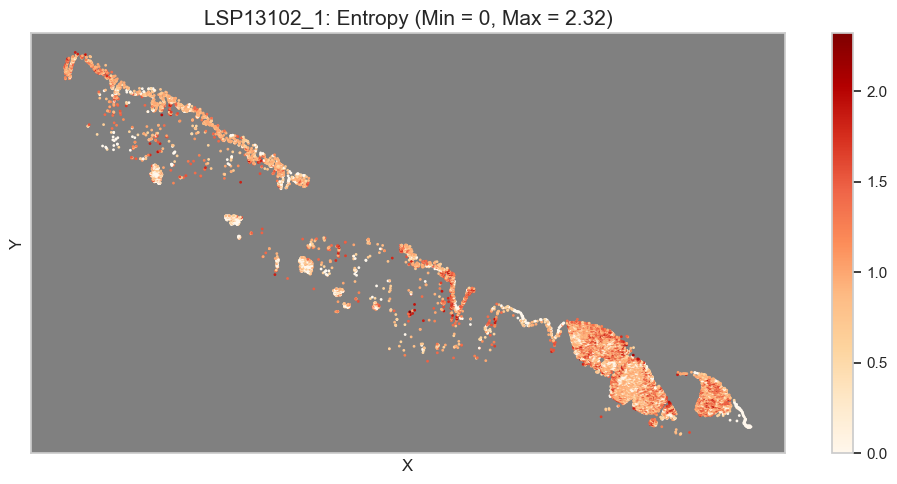

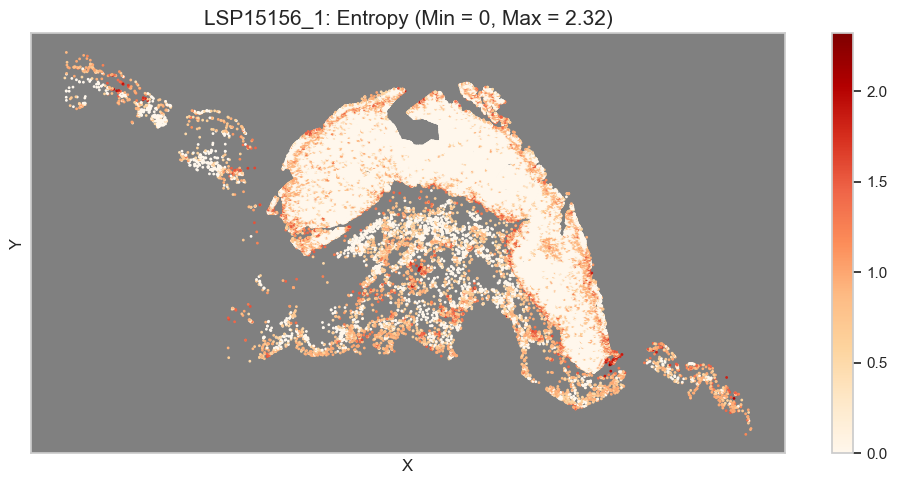

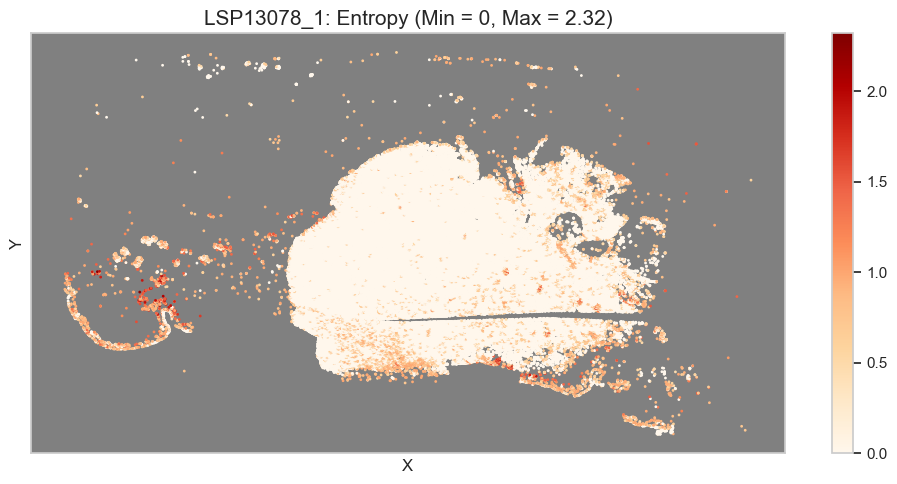

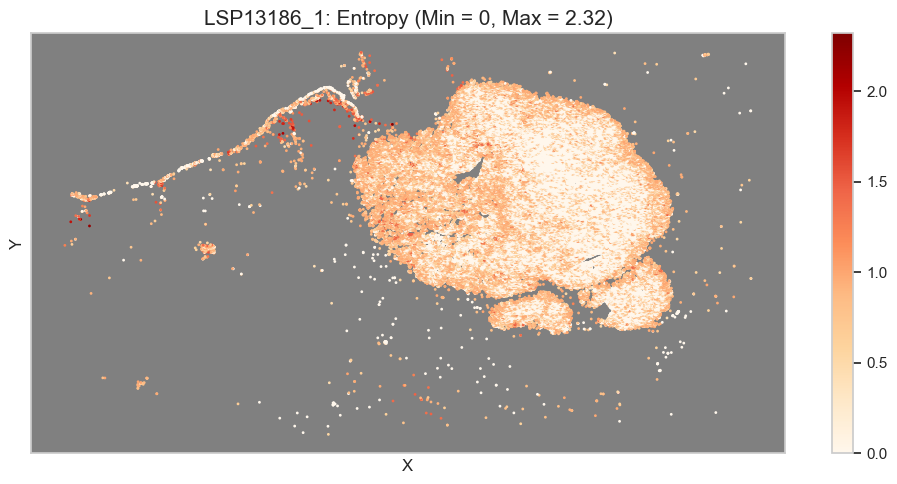

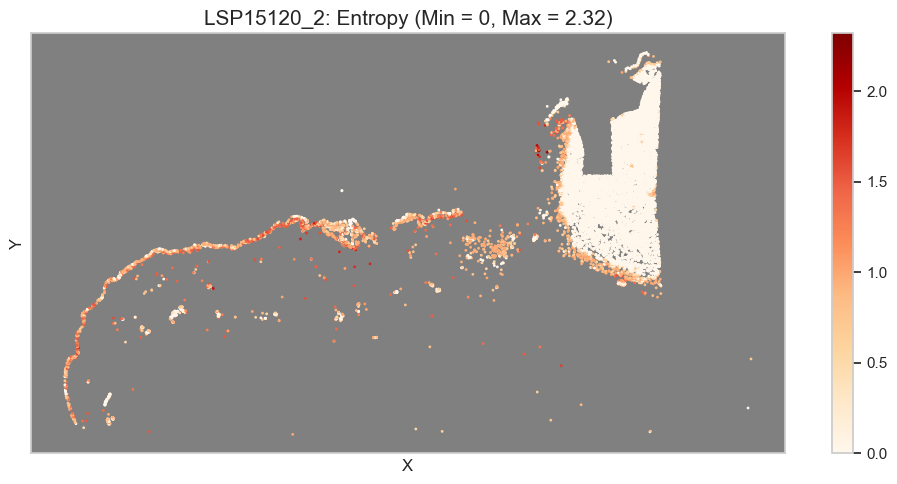

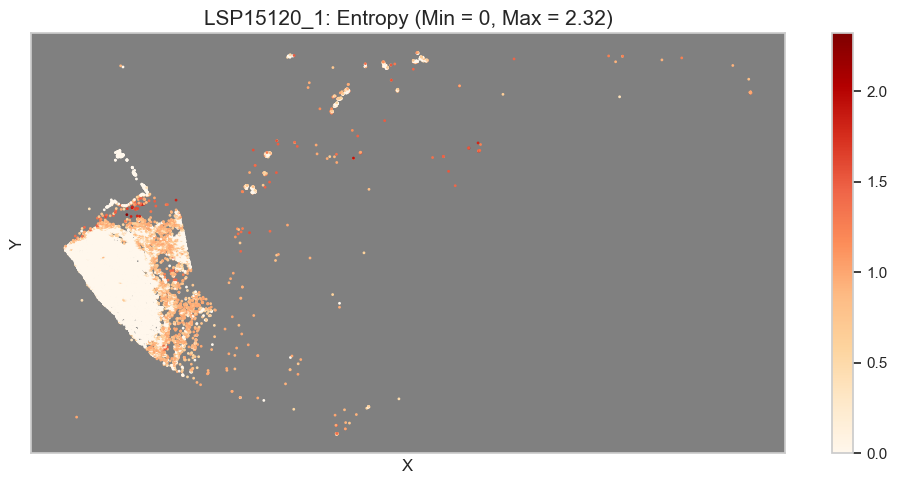

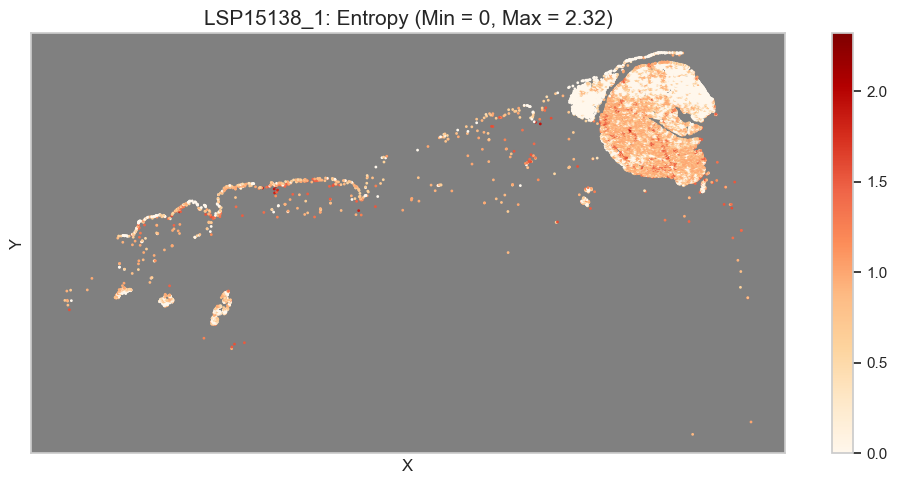

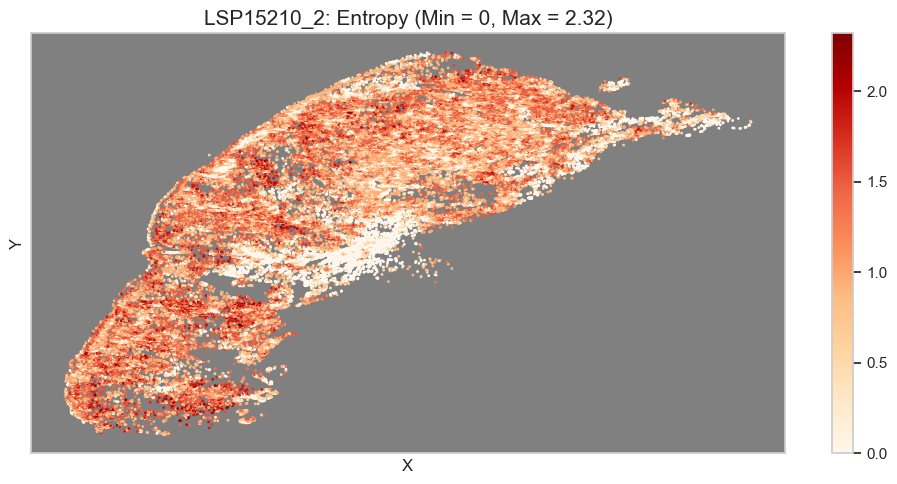

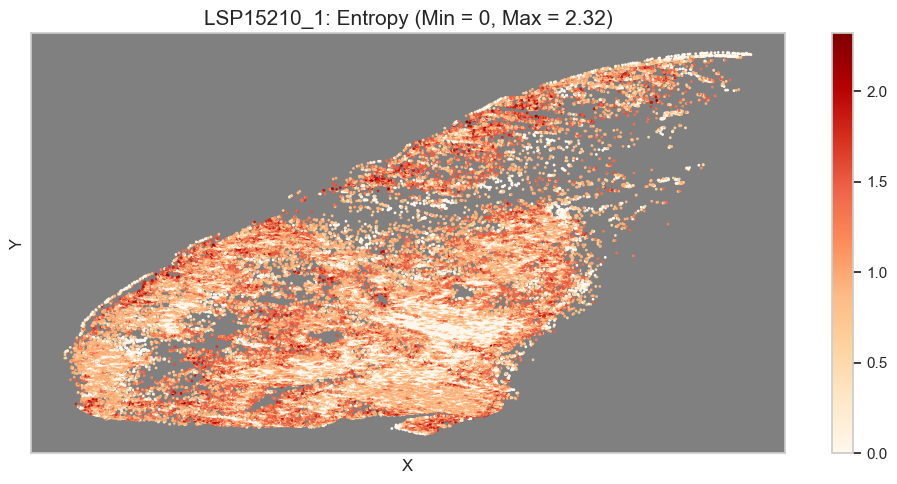

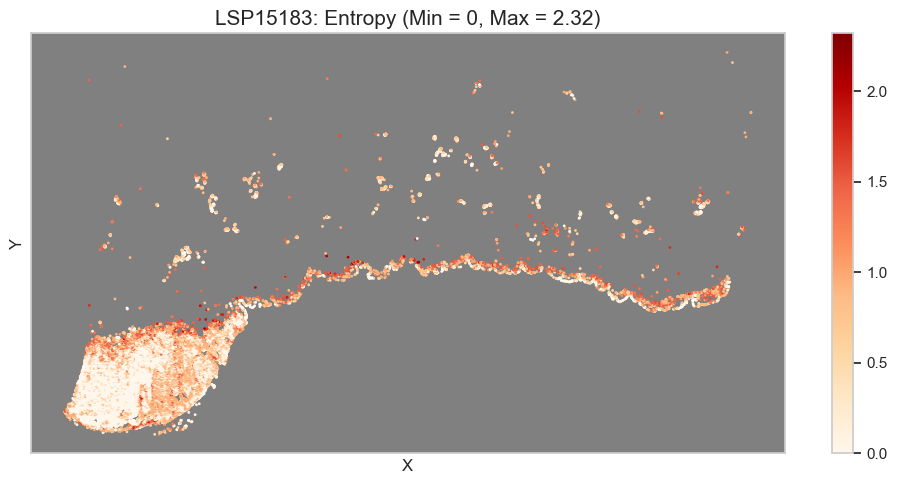

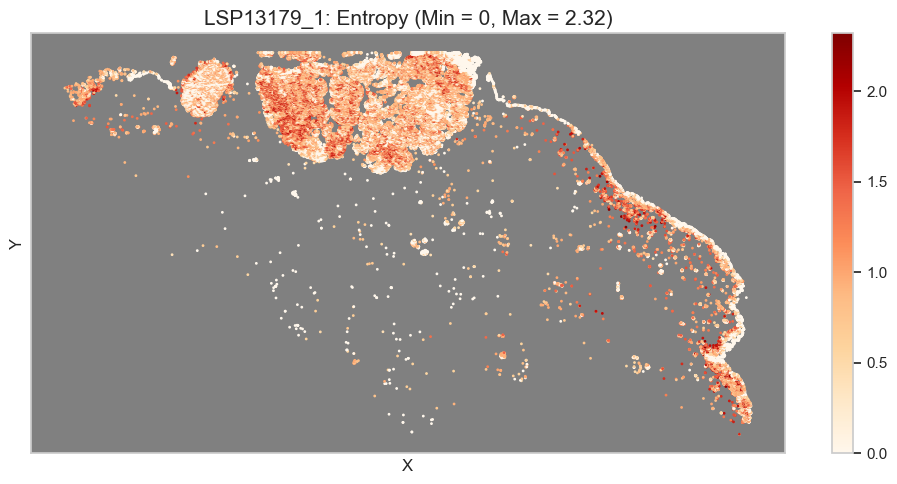

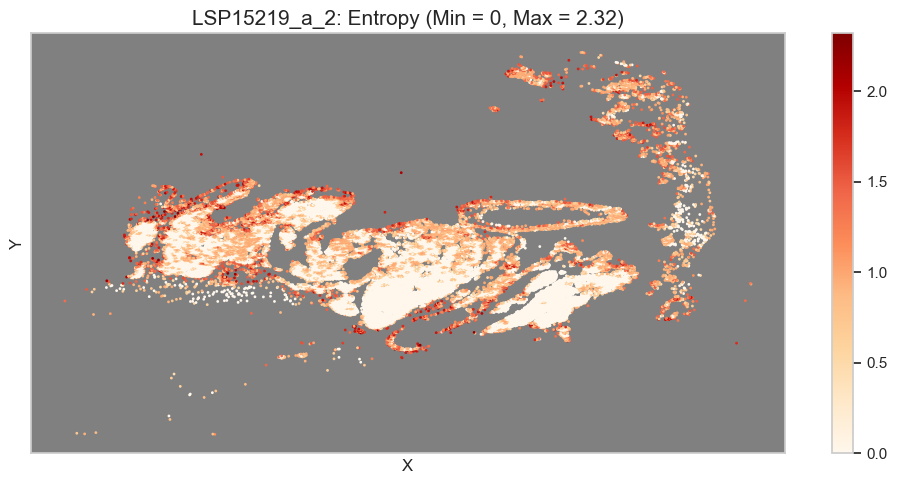

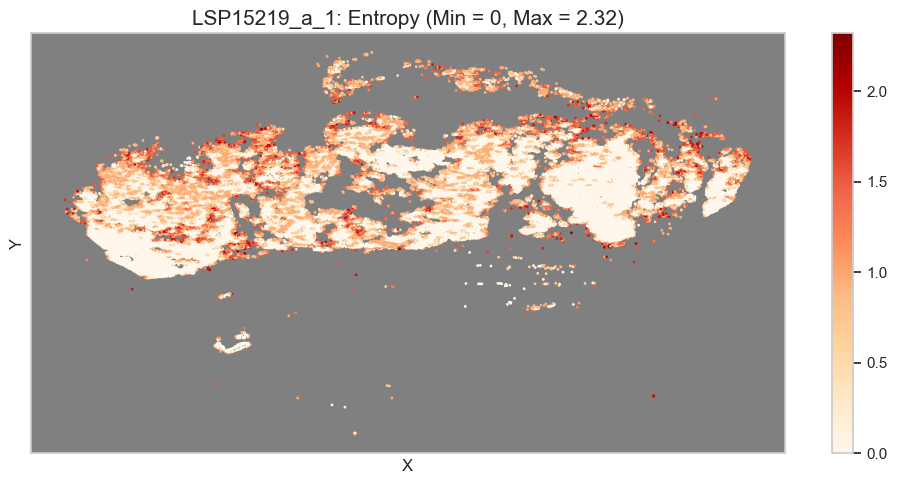

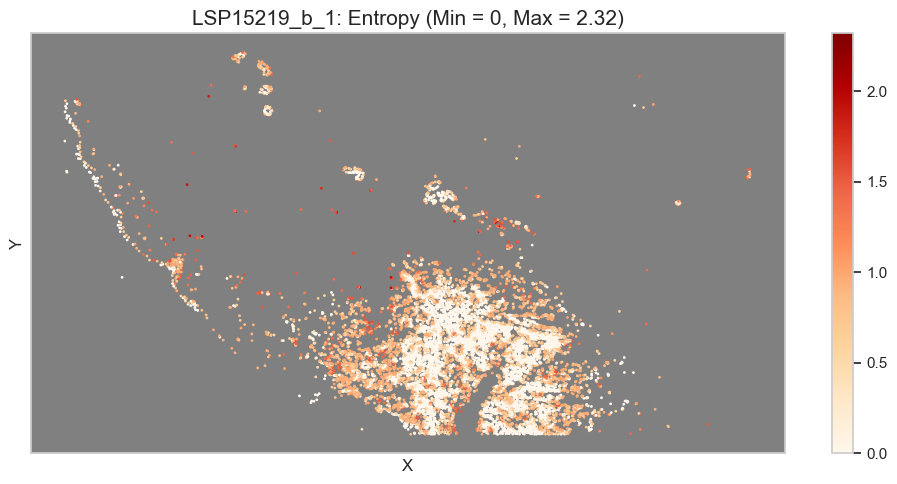

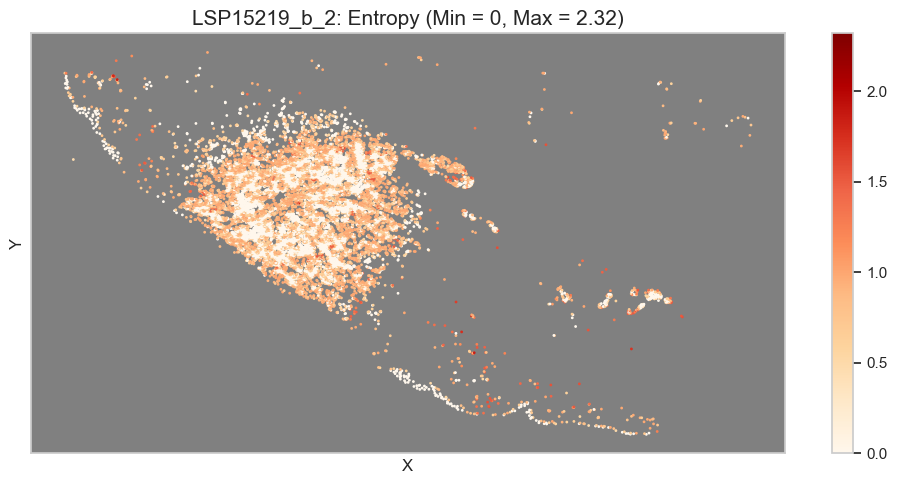

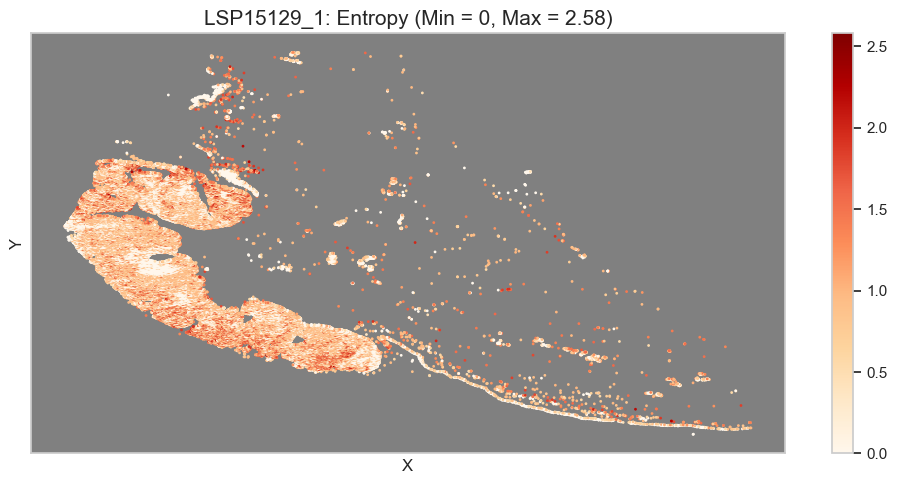

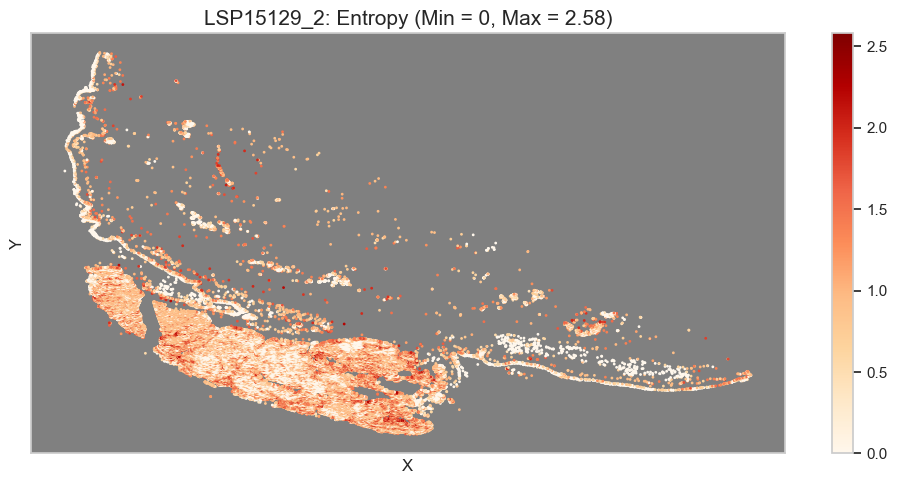

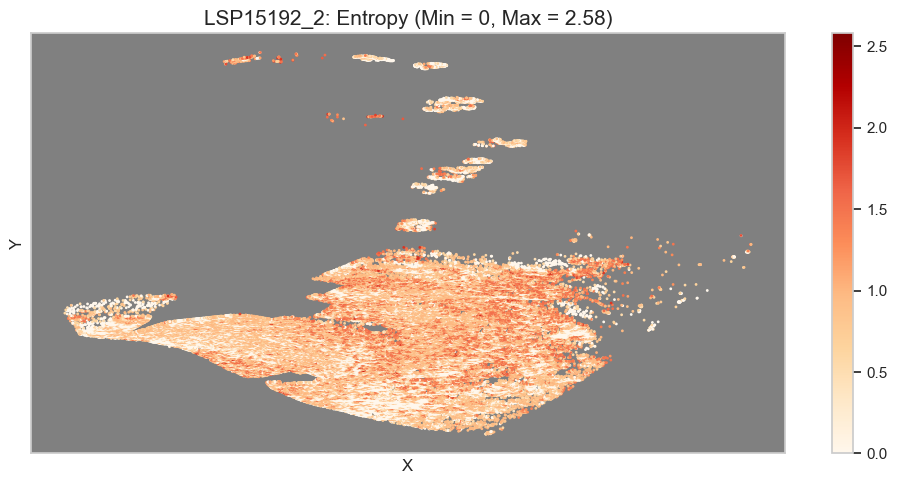

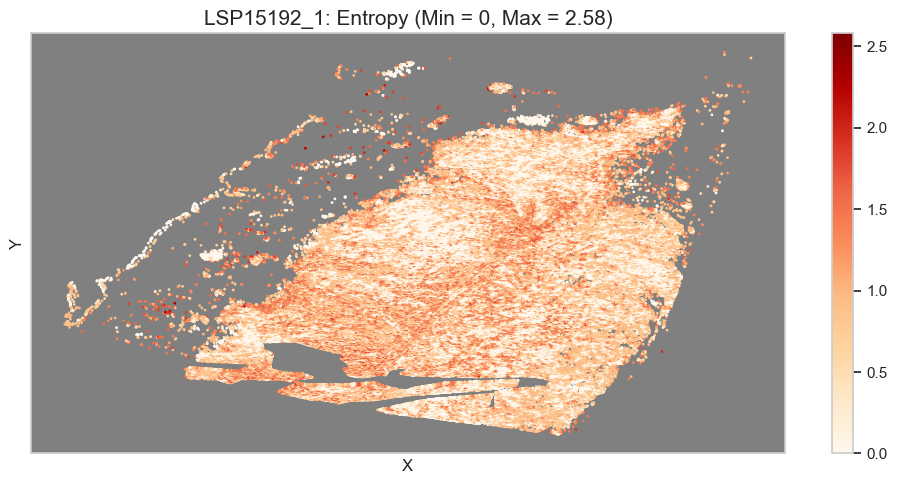

In [42]:
calculate_nbhd_entropy_per_cell(adata, node_attribute_name='simplified_phenotype', sample_column_name='contiguous_spatial', base=None)

### Spatial entropy of GeoMX ROIs

GeoMX Region LSP13099_007 shape: (351, 28)
Average number of neighbors per cell = 5.84045584045584
GeoMX Region LSP13099_025 shape: (3, 28)
Skipping GeoMX Region: LSP13099_025
GeoMX Region LSP13099_010 shape: (336, 28)
Average number of neighbors per cell = 5.821428571428571
GeoMX Region LSP13099_011 shape: (287, 28)
Average number of neighbors per cell = 5.811846689895471
GeoMX Region LSP13099_008 shape: (369, 28)
Average number of neighbors per cell = 5.853658536585366
GeoMX Region LSP13099_005 shape: (300, 28)
Average number of neighbors per cell = 5.866666666666666
GeoMX Region LSP13099_006 shape: (321, 28)
Average number of neighbors per cell = 5.844236760124611
GeoMX Region LSP13099_024 shape: (3, 28)
Skipping GeoMX Region: LSP13099_024
GeoMX Region LSP13099_009 shape: (217, 28)
Average number of neighbors per cell = 5.84331797235023
GeoMX Region LSP13099_027 shape: (20, 28)
Average number of neighbors per cell = 4.9
GeoMX Region LSP13099_002 shape: (245, 28)
Average number of ne

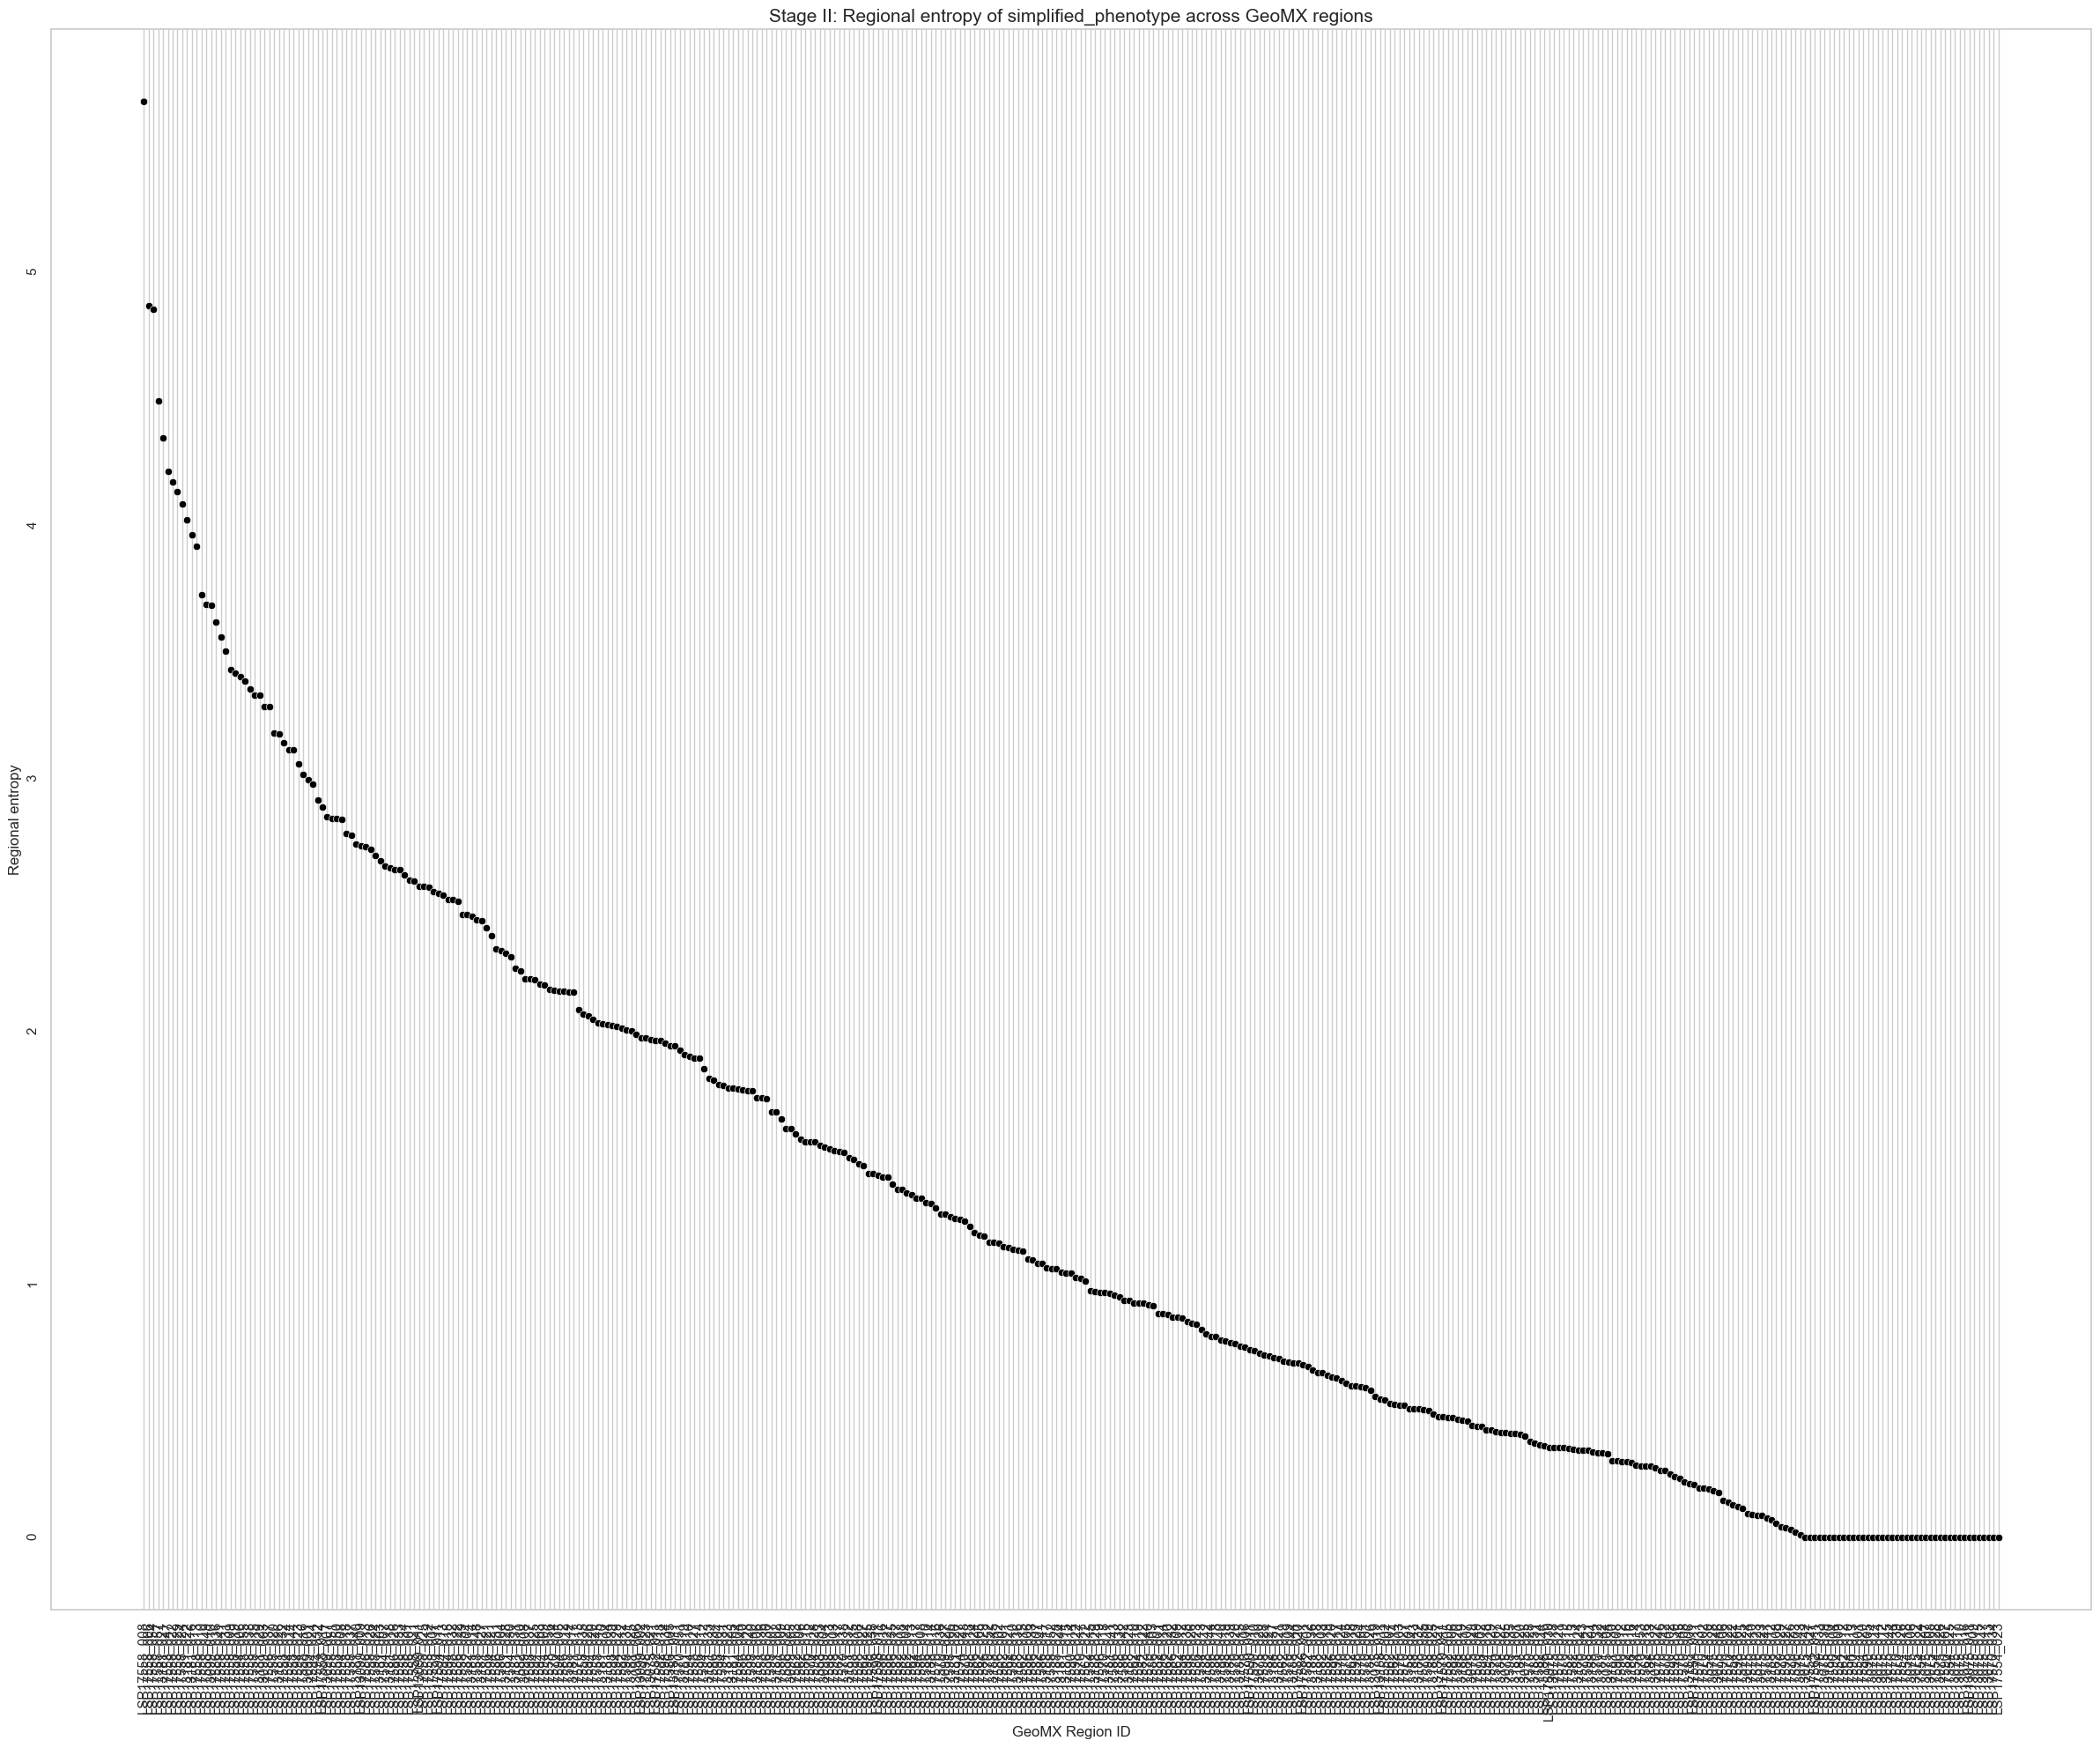

In [25]:
H_spatial_df = heterogeneity_by_GeoMX_regions(adata, node_attribute_name='simplified_phenotype')

In [26]:
H_spatial_df.to_csv('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/stage2_regional_entropy_geomx_rois_06182024.csv', index=False)

In [19]:
print(adata.obs.geomx_aoi.value_counts())

print((adata.obs.geomx_aoi.value_counts() > 1).sum())
print((adata.obs.geomx_aoi.value_counts() == 1).tail(7))

Other           1574729
LSP17598_037       3904
LSP17598_010       2160
LSP17594_006       2142
LSP17594_009       1779
                 ...   
LSP13188_034          1
LSP13075_030          1
LSP13188_041          1
LSP13075_034          1
LSP13099_026          1
Name: geomx_aoi, Length: 412, dtype: int64
406
LSP17562_025    False
LSP13188_001     True
LSP13188_034     True
LSP13075_030     True
LSP13188_041     True
LSP13075_034     True
LSP13099_026     True
Name: geomx_aoi, dtype: bool


### Boxplot of spatial entropy - both including and removing stage II samples with high NGFR 

In [40]:
# samples with high NGFR+: LSP 15210, 15192, 13186, 15120, 13078
def heterogeneity_per_stage2_sample(adata, node_attribute_name, sample_column_name='imageid', sample_list=None):
    data = adata.copy() # stage 2 samples contain all tumor cells by default

    if sample_list:
        pass
    else:
        sample_list = data.obs[sample_column_name].unique().tolist()
    H_spatial_dict = {}
    ngfr_high_exclusion_list = ['Other', 'LSP15210', 'LSP15192', 'LSP13186', 'LSP15120', 'LSP13078']
    for sample in sample_list:
        if any([patient for patient in ngfr_high_exclusion_list if patient in sample]):
            continue
        df = data[data.obs[sample_column_name] == sample].obs
        G, graph_dict = make_graph(df, node_attribute_name=node_attribute_name)
        H_spatial = calculate_spatial_entropy(df, G, graph_dict, node_attribute_name=node_attribute_name)
        H_spatial_dict[sample] = H_spatial
    
    H_spatial_df = pd.DataFrame.from_dict(H_spatial_dict, orient='index').reset_index().rename(columns={'index': 'sample', 0:'H_spatial'}).sort_values(by='H_spatial', ascending=False)
    fig, ax = plt.subplots(figsize=(12,10))
    sns.boxplot(data=H_spatial_df, showfliers = False, whis=1, showmeans=True, meanprops={'marker':'o',
                                                                                                'markerfacecolor':'black', 
                                                                                                'markeredgecolor':'black',
                                                                                                'markersize':'8'})
    ax.set_title(f'Spatial heterogeneity of {node_attribute_name} across progression stages', fontsize=15)
    ax.set_xlabel('Progression stage')
    ax.set_ylabel('Spatial entropy')
    fig.tight_layout()

Average number of neighbors per cell = 5.997112922002328
Average number of neighbors per cell = 5.9997343745849605
Average number of neighbors per cell = 5.9976640971735575
Average number of neighbors per cell = 5.998918594172424
Average number of neighbors per cell = 5.999410192608976
Average number of neighbors per cell = 5.998530546269424
Average number of neighbors per cell = 5.9989697890643106
Average number of neighbors per cell = 5.995647873392681
Average number of neighbors per cell = 5.996288100506817
Average number of neighbors per cell = 5.999735292775318
Average number of neighbors per cell = 5.999545106301475


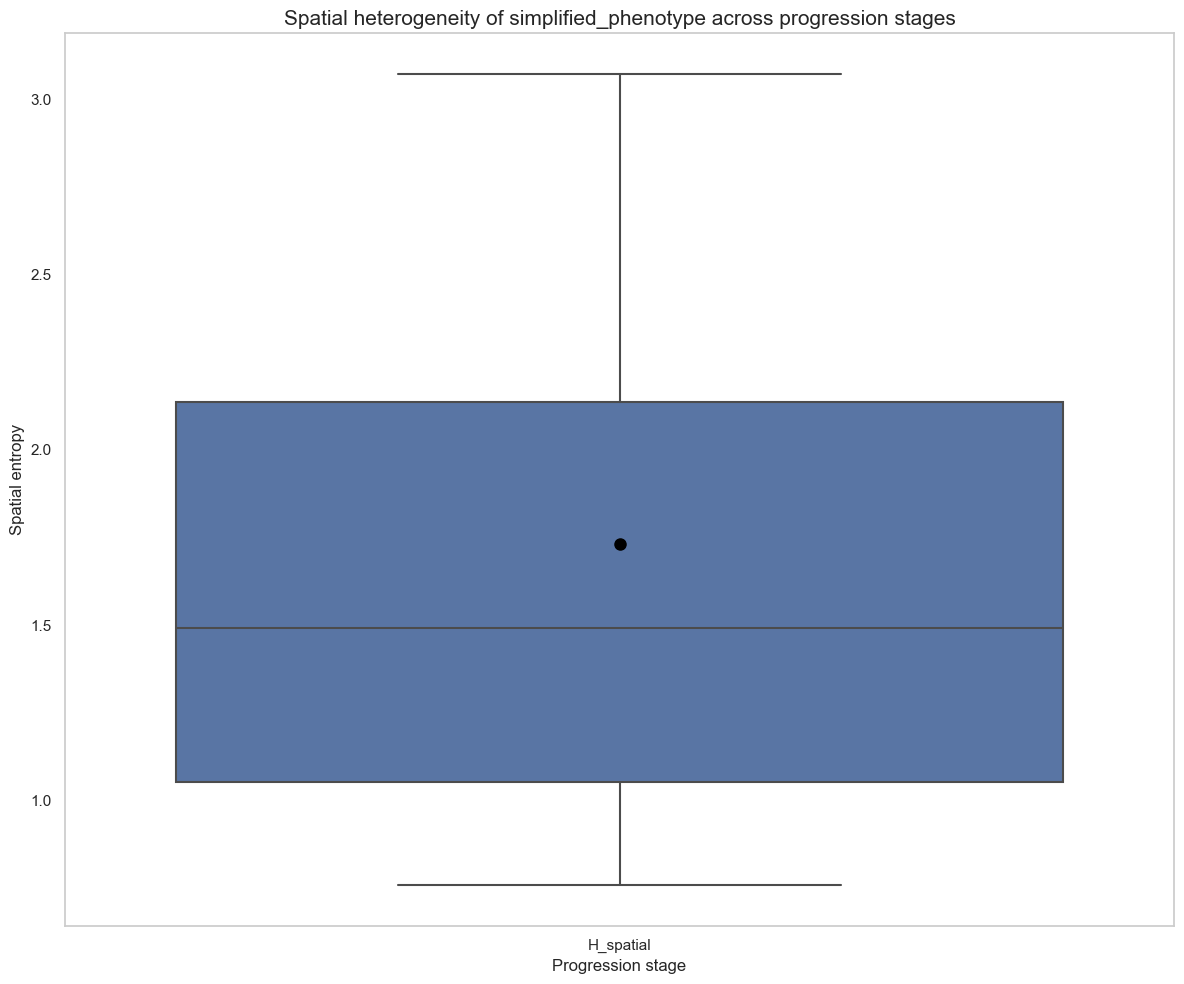

In [41]:
heterogeneity_per_stage2_sample(adata, node_attribute_name='simplified_phenotype', sample_column_name='contiguous_spatial')

In [14]:
# combine spatial-entropy-analysis.ipynb: heterogeneity_by_comparable_progression_stages() for stage I with column for stage II.
def heterogeneity_per_stage2_sample_with_stage1(adata_stage2, adata_stage1, sample_dict_stage1, node_attribute_name_stage2, node_attribute_name_stage1, sample_column_name_stage2='imageid', sample_list_stage2=None, violin_plot=False, include_ngfr_high=False):
    # Assemable stage 2 entropies across samples
    data_stage2 = adata_stage2.copy() # stage 2 samples contain all tumor cells by default

    if sample_list_stage2:
        pass
    else:
        sample_list_stage2 = data_stage2.obs[sample_column_name_stage2].unique().tolist()
    H_spatial_dict_stage2 = {}
    ngfr_high_exclusion_list = ['Other', 'LSP15210', 'LSP15192', 'LSP13186', 'LSP15120', 'LSP13078']
    for sample in sample_list_stage2:
        if include_ngfr_high:
            if sample == 'Other':
                continue
            df_stage2 = data_stage2[data_stage2.obs[sample_column_name_stage2] == sample].obs
            G_stage2, graph_dict_stage2 = make_graph(df_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_stage2 = calculate_spatial_entropy(df_stage2, G_stage2, graph_dict_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_dict_stage2[sample] = H_spatial_stage2
        else:
            if any([patient for patient in ngfr_high_exclusion_list if patient in sample]):
                continue
            df_stage2 = data_stage2[data_stage2.obs[sample_column_name_stage2] == sample].obs
            G_stage2, graph_dict_stage2 = make_graph(df_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_stage2 = calculate_spatial_entropy(df_stage2, G_stage2, graph_dict_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_dict_stage2[sample] = H_spatial_stage2
    
    H_spatial_series_stage2 = pd.Series(H_spatial_dict_stage2.values())

    # Assemble stage 1 entropies across samples
    adata_1 = adata_stage1[adata_stage1.obs.lineage_grouped != 'SOX10-'] # all tumor cells
    adata_2 = adata_1[adata_1.obs.ROI != 'dysplastic nevus']
    data_stage1 = adata_2[adata_2.obs.ROI != 'Other']
    
    H_spatial_dict_stage1 = {}
    for roi_key, sample_list_stage1 in sample_dict_stage1.items():
        H_spatial_dict_per_roi = {}
        #print(roi, sample_list)
        for sample in sample_list_stage1:
            sample_df_stage1 = data_stage1[data_stage1.obs.imageid == sample]
            roi_list = sample_df_stage1.obs.ROI.unique().tolist()
            #print(f'{sample}: {roi_list}')
            roi_dict = {}
            for roi_name in roi_list:
                if roi_key in roi_name:
                    df_stage1 = sample_df_stage1[sample_df_stage1.obs.ROI == roi_name].obs
                    if df_stage1.shape[0] == 0:
                        continue
                    G_stage1, graph_dict_stage1 = make_graph(df_stage1, node_attribute_name=node_attribute_name_stage1)
                    H_spatial_stage1 = calculate_spatial_entropy(df_stage1, G_stage1, graph_dict_stage1, node_attribute_name=node_attribute_name_stage1)
                    roi_dict[roi_name] = H_spatial_stage1
            H_spatial_dict_per_roi[sample] = roi_dict
        H_spatial_dict_stage1[roi_key] = H_spatial_dict_per_roi
    
    roi_progression_dict = {}
    for _, sample_values_dict in H_spatial_dict_stage1.items():
        for _, roi_values_dict in sample_values_dict.items():
            for roi_name, roi_value in roi_values_dict.items():
                roi_short_name = roi_name.split('_')[0]
                roi_progression_dict.setdefault(roi_short_name,[]).append(roi_value)
    
    roi_progression_median_dict = {k:np.median(v) for k, v in roi_progression_dict.items()}
    roi_name_order = list({k:v for k,v in sorted(roi_progression_median_dict.items(), key=lambda x: x[1])}.keys())
    roi_progression_df = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in roi_progression_dict.items()])) # accounts for different length lists
    roi_progression_df = roi_progression_df[roi_name_order]

    # Combine stage1 and stage2
    roi_progression_df['Stage II'] = H_spatial_series_stage2

    # Plot
    fig, ax = plt.subplots(figsize=(12,10))
    if violin_plot:
        sns.violinplot(data=roi_progression_df, showfliers = False, whis=1, showmeans=True, meanprops={'marker':'o',
                                                                                                    'markerfacecolor':'black', 
                                                                                                    'markeredgecolor':'black',
                                                                                                    'markersize':'8'})
    else:
        sns.boxplot(data=roi_progression_df, showfliers = False, whis=1, showmeans=True, meanprops={'marker':'o',
                                                                                                    'markerfacecolor':'black', 
                                                                                                    'markeredgecolor':'black',
                                                                                                    'markersize':'8'})
    ax.set_title(f'Spatial heterogeneity of tumor phenotypes across progression stages', fontsize=15)
    ax.set_xlabel('Progression stage')
    ax.set_ylabel('Spatial entropy')
    fig.tight_layout()
    if include_ngfr_high:
        plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/spatial_entropy/spatial_entropy_tumor_phenotypes_across_comparable_progression_ROIs_and_stage2_including_ngfr_high_samples.pdf", format="pdf", bbox_inches="tight")
    else:
        plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/spatial_entropy/spatial_entropy_tumor_phenotypes_across_comparable_progression_ROIs_and_stage2_without_ngfr_high_samples.pdf", format="pdf", bbox_inches="tight")

Average number of neighbors per cell = 5.997112922002328
Average number of neighbors per cell = 5.9997343745849605
Average number of neighbors per cell = 5.9976640971735575
Average number of neighbors per cell = 5.998918594172424
Average number of neighbors per cell = 5.999410192608976
Average number of neighbors per cell = 5.998530546269424
Average number of neighbors per cell = 5.9989697890643106
Average number of neighbors per cell = 5.995647873392681
Average number of neighbors per cell = 5.996288100506817
Average number of neighbors per cell = 5.999735292775318
Average number of neighbors per cell = 5.999545106301475
Average number of neighbors per cell = 5.985957873620863
Average number of neighbors per cell = 5.974731522425774
Average number of neighbors per cell = 5.998253681820827
Average number of neighbors per cell = 5.985996180776575
Average number of neighbors per cell = 5.993311931514179
Average number of neighbors per cell = 5.994695700725852
Average number of neighbors 

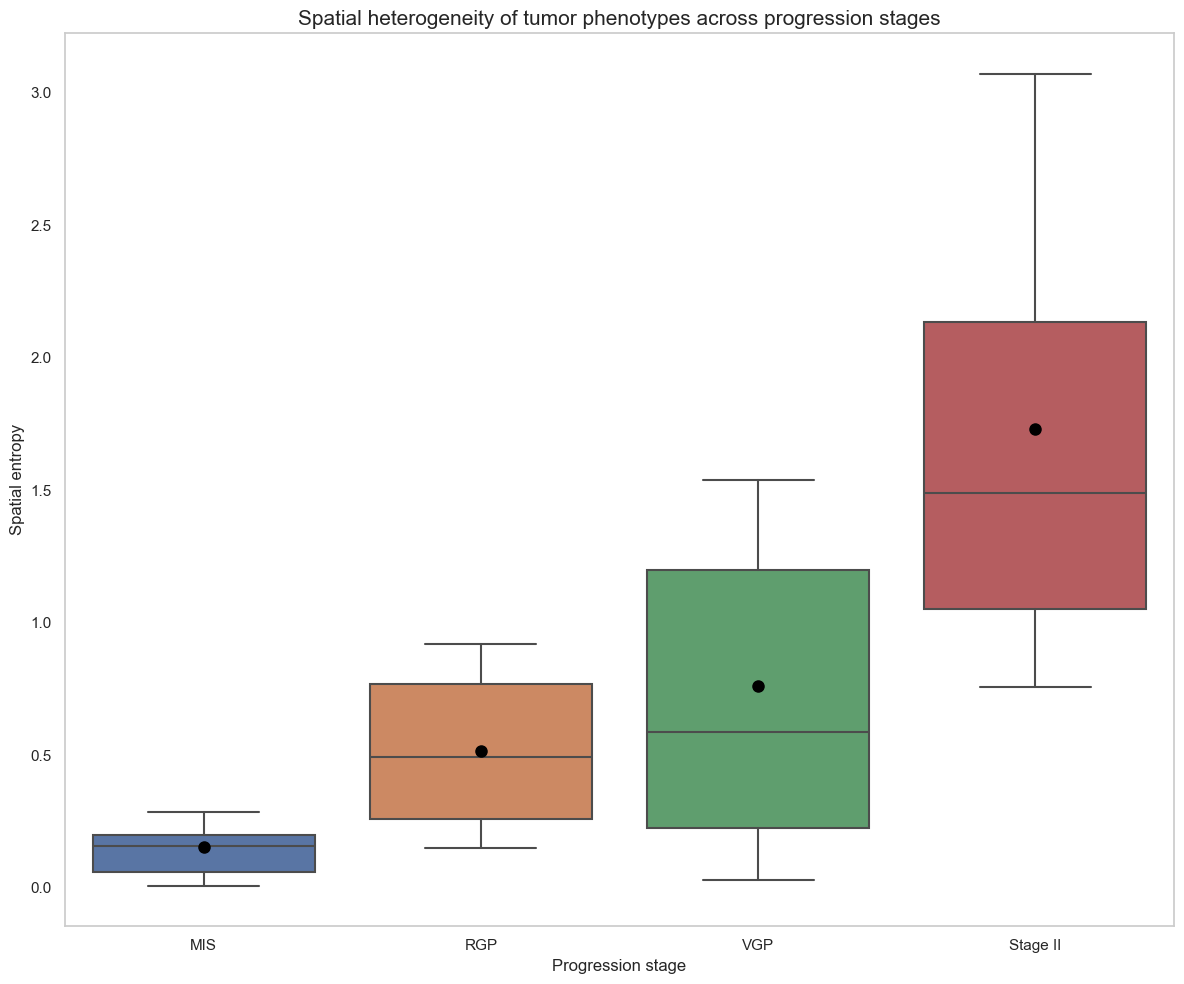

In [10]:
# Comparable VGP, RGP, MIS regions for graph analysis
adata_stage1 = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/reannotated_progression_ROIs/adata_e24_merged_splits_v4_09182023.h5ad')
adata_stage2 = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/pca_stage2_samples/p135_e9_adtumorV5_TV.h5ad')

sample_dict_stage1 = {
               'VGP': ['LSP11411_lower_upper', 'LSP11411_upper', 'LSP11643_right_upper', 'LSP11355_lower_left', 'LSP11355_lower_right_right', 'LSP11355_upper', 'LSP11563_upper', 'LSP11595', 'LSP11747_upper'],
               'RGP': ['LSP11691_left', 'LSP11691_right', 'LSP11411_lower_upper', 'LSP11411_upper', 'LSP12422_left', 'LSP12422_right', 'LSP11315_right_upper', 'LSP11315_left_upper'],
               'MIS': ['LSP11523_upper', 'LSP11387_left_upper', 'LSP11387_right', 'LSP11347_lesion_b', 'LSP11347_lesion_a', 'LSP11691_left', 'LSP11691_right']
              }

heterogeneity_per_stage2_sample_with_stage1(adata_stage2, adata_stage1, sample_dict_stage1, node_attribute_name_stage2='simplified_phenotype', node_attribute_name_stage1='lineage_grouped', sample_column_name_stage2='contiguous_spatial')

Average number of neighbors per cell = 5.997112922002328
Average number of neighbors per cell = 5.9997343745849605
Average number of neighbors per cell = 5.999682302181867
Average number of neighbors per cell = 5.999737217262198
Average number of neighbors per cell = 5.9964717480413015
Average number of neighbors per cell = 5.998657042135303
Average number of neighbors per cell = 5.9976640971735575
Average number of neighbors per cell = 5.998485789718901
Average number of neighbors per cell = 5.998641324859226
Average number of neighbors per cell = 5.998918594172424
Average number of neighbors per cell = 5.999410192608976
Average number of neighbors per cell = 5.998530546269424
Average number of neighbors per cell = 5.9989697890643106
Average number of neighbors per cell = 5.995647873392681
Average number of neighbors per cell = 5.996288100506817
Average number of neighbors per cell = 5.999735292775318
Average number of neighbors per cell = 5.999545106301475
Average number of neighbors

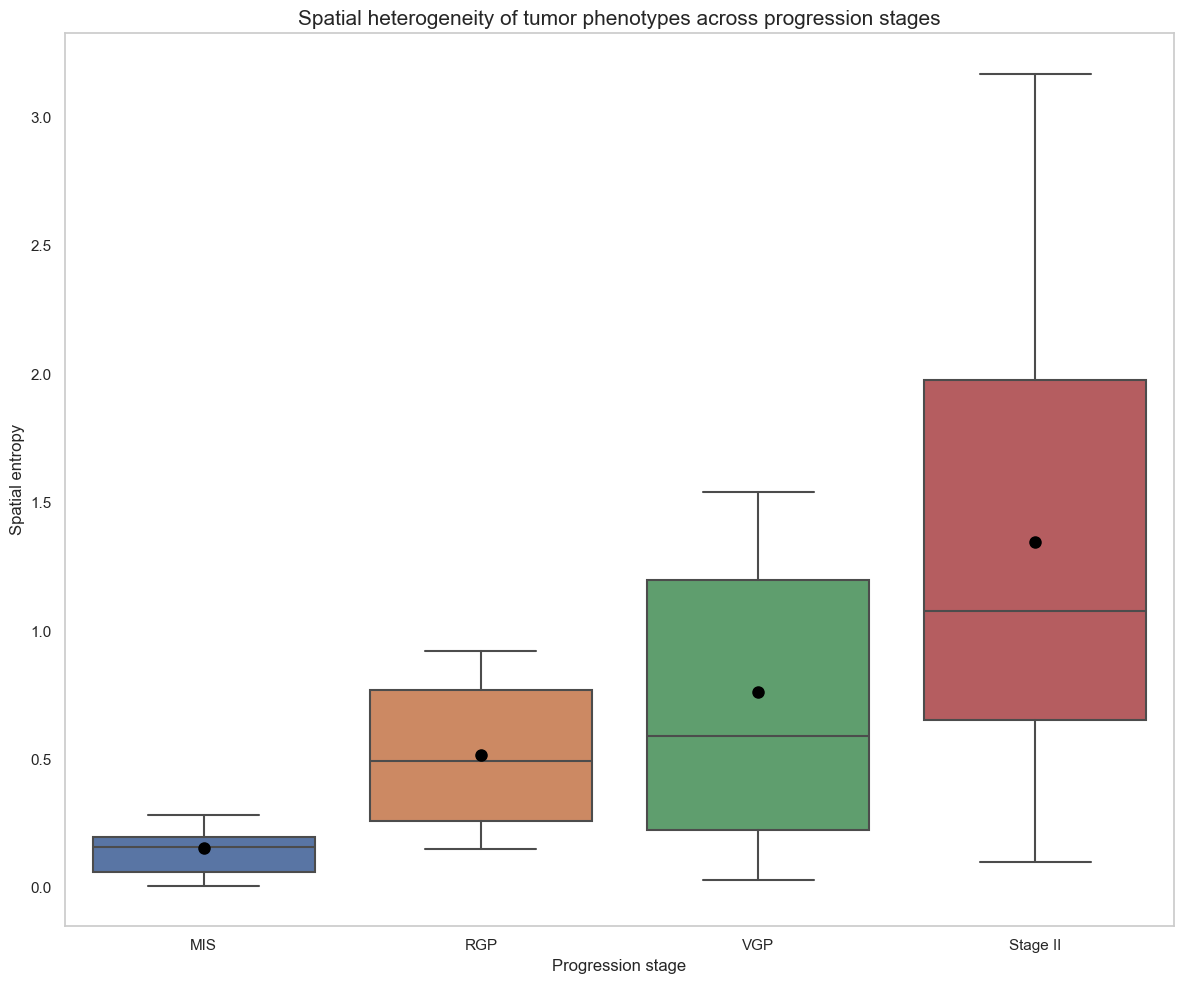

In [11]:
heterogeneity_per_stage2_sample_with_stage1(adata_stage2, adata_stage1, sample_dict_stage1, node_attribute_name_stage2='simplified_phenotype', node_attribute_name_stage1='lineage_grouped', sample_column_name_stage2='contiguous_spatial', include_ngfr_high=True)

### Boxplots with statistical significance

In [5]:
# https://levelup.gitconnected.com/statistics-on-seaborn-plots-with-statannotations-2bfce0394c00
# https://github.com/trevismd/statannotations-tutorials/blob/main/Tutorial_1/Statannotations-Tutorial-1.ipynb
# https://stackoverflow.com/questions/36578458/how-does-one-insert-statistical-annotations-stars-or-p-values
from utils import *
from statannotations.Annotator import Annotator
from scipy.stats import mannwhitneyu

In [9]:
# combine spatial-entropy-analysis.ipynb: heterogeneity_by_comparable_progression_stages() for stage I with column for stage II.
def heterogeneity_per_stage2_sample_with_stage1(adata_stage2, adata_stage1, sample_dict_stage1, node_attribute_name_stage2, node_attribute_name_stage1, sample_column_name_stage2='imageid', sample_list_stage2=None, violin_plot=False, include_ngfr_high=False):
    # Assemable stage 2 entropies across samples
    data_stage2 = adata_stage2.copy() # stage 2 samples contain all tumor cells by default

    if sample_list_stage2:
        pass
    else:
        sample_list_stage2 = data_stage2.obs[sample_column_name_stage2].unique().tolist()
    H_spatial_dict_stage2 = {}
    ngfr_high_exclusion_list = ['Other', 'LSP15210', 'LSP15192', 'LSP13186', 'LSP15120', 'LSP13078']
    for sample in sample_list_stage2:
        if include_ngfr_high:
            if sample == 'Other':
                continue
            df_stage2 = data_stage2[data_stage2.obs[sample_column_name_stage2] == sample].obs
            G_stage2, graph_dict_stage2 = make_graph(df_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_stage2 = calculate_spatial_entropy(df_stage2, G_stage2, graph_dict_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_dict_stage2[sample] = H_spatial_stage2
        else:
            if any([patient for patient in ngfr_high_exclusion_list if patient in sample]):
                continue
            df_stage2 = data_stage2[data_stage2.obs[sample_column_name_stage2] == sample].obs
            G_stage2, graph_dict_stage2 = make_graph(df_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_stage2 = calculate_spatial_entropy(df_stage2, G_stage2, graph_dict_stage2, node_attribute_name=node_attribute_name_stage2)
            H_spatial_dict_stage2[sample] = H_spatial_stage2
    
    H_spatial_series_stage2 = pd.Series(H_spatial_dict_stage2.values())

    # Assemble stage 1 entropies across samples
    adata_1 = adata_stage1[adata_stage1.obs.lineage_grouped != 'SOX10-'] # all tumor cells
    adata_2 = adata_1[adata_1.obs.ROI != 'dysplastic nevus']
    data_stage1 = adata_2[adata_2.obs.ROI != 'Other']
    
    H_spatial_dict_stage1 = {}
    for roi_key, sample_list_stage1 in sample_dict_stage1.items():
        H_spatial_dict_per_roi = {}
        #print(roi, sample_list)
        for sample in sample_list_stage1:
            sample_df_stage1 = data_stage1[data_stage1.obs.imageid == sample]
            roi_list = sample_df_stage1.obs.ROI.unique().tolist()
            #print(f'{sample}: {roi_list}')
            roi_dict = {}
            for roi_name in roi_list:
                if roi_key in roi_name:
                    df_stage1 = sample_df_stage1[sample_df_stage1.obs.ROI == roi_name].obs
                    if df_stage1.shape[0] == 0:
                        continue
                    G_stage1, graph_dict_stage1 = make_graph(df_stage1, node_attribute_name=node_attribute_name_stage1)
                    H_spatial_stage1 = calculate_spatial_entropy(df_stage1, G_stage1, graph_dict_stage1, node_attribute_name=node_attribute_name_stage1)
                    roi_dict[roi_name] = H_spatial_stage1
            H_spatial_dict_per_roi[sample] = roi_dict
        H_spatial_dict_stage1[roi_key] = H_spatial_dict_per_roi
    
    roi_progression_dict = {}
    for _, sample_values_dict in H_spatial_dict_stage1.items():
        for _, roi_values_dict in sample_values_dict.items():
            for roi_name, roi_value in roi_values_dict.items():
                roi_short_name = roi_name.split('_')[0]
                roi_progression_dict.setdefault(roi_short_name,[]).append(roi_value)
    
    roi_progression_median_dict = {k:np.median(v) for k, v in roi_progression_dict.items()}
    roi_name_order = list({k:v for k,v in sorted(roi_progression_median_dict.items(), key=lambda x: x[1])}.keys())
    roi_progression_df = pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in roi_progression_dict.items()])) # accounts for different length lists
    roi_progression_df = roi_progression_df[roi_name_order]

    # Combine stage1 and stage2
    roi_progression_df['Stage II'] = H_spatial_series_stage2

    pairs = [
                ('MIS', 'RGP'),
                ('RGP', 'VGP'),
                ('VGP', 'Stage II'),
                ('MIS', 'VGP'),
                ('MIS', 'Stage II'),
                ('RGP', 'Stage II')
            ]

    MIS = roi_progression_df['MIS'].dropna().values
    RGP = roi_progression_df['RGP'].dropna().values
    VGP = roi_progression_df['VGP'].dropna().values
    StageII = roi_progression_df['Stage II'].dropna().values

    stat_results = [
                        mannwhitneyu(MIS, RGP, alternative="two-sided"),
                        mannwhitneyu(RGP, VGP, alternative="two-sided"),
                        mannwhitneyu(VGP, StageII, alternative="two-sided"),
                        mannwhitneyu(MIS, VGP, alternative="two-sided"),
                        mannwhitneyu(MIS, StageII, alternative="two-sided"),
                        mannwhitneyu(RGP, StageII, alternative="two-sided")
                    ]
    print("MIS vs RGP: ", stat_results[0])
    print("RGP vs VGP: ", stat_results[1])
    print("VGP vs Stage II: ", stat_results[2])
    print("MIS vs VGP: ", stat_results[3])
    print("MIS vs Stage II: ", stat_results[4])
    print("RGP vs Stage II: ", stat_results[5])

    pvalues = [result.pvalue for result in stat_results]
    formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

    plotting_params = {
                            'data': roi_progression_df,
                            'showfliers': False,
                            'whis': 1,
                            'showmeans': True,
                            'meanprops': {'marker':'o',
                                        'markerfacecolor':'black', 
                                        'markeredgecolor':'black',
                                        'markersize':'8'}
                    }
    
    # Plot
    fig, ax = plt.subplots(figsize=(12,10))
    if violin_plot:
        sns.violinplot(**plotting_params)
    else:
        sns.boxplot(**plotting_params)
    # add statistical significance annotations
    annotator = Annotator(ax, pairs, **plotting_params)
    ### Option 1 - 1e-2 format ###
    # annotator.set_custom_annotations(formatted_pvalues)
    ### Option 2 - *** / ns format ###
    # annotator.set_pvalues(pvalues)
    ### Option 3 - < 0.05 if significant, else show 0.66 format ###
    annotator.configure(text_format="simple", verbose=0)
    annotator.set_pvalues(pvalues)
    annotator.annotate()

    ax.set_title(f'Spatial heterogeneity of tumor phenotypes across progression stages', fontsize=15)
    ax.set_xlabel('Progression stage')
    ax.set_ylabel('Spatial entropy')
    fig.tight_layout()    
    if include_ngfr_high:
        plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/spatial_entropy/spatial_entropy_tumor_phenotypes_across_comparable_progression_ROIs_and_stage2_including_ngfr_high_samples_with_significance.pdf", format="pdf", bbox_inches="tight")
    else:
        plt.savefig(f"/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/figures/spatial_entropy/spatial_entropy_tumor_phenotypes_across_comparable_progression_ROIs_and_stage2_without_ngfr_high_samples_with_significance.pdf", format="pdf", bbox_inches="tight")
    # return roi_progression_df

Average number of neighbors per cell = 5.997112922002328
Average number of neighbors per cell = 5.9997343745849605
Average number of neighbors per cell = 5.9976640971735575
Average number of neighbors per cell = 5.998918594172424
Average number of neighbors per cell = 5.999410192608976
Average number of neighbors per cell = 5.998530546269424
Average number of neighbors per cell = 5.9989697890643106
Average number of neighbors per cell = 5.995647873392681
Average number of neighbors per cell = 5.996288100506817
Average number of neighbors per cell = 5.999735292775318
Average number of neighbors per cell = 5.999545106301475
Average number of neighbors per cell = 5.985957873620863
Average number of neighbors per cell = 5.974731522425774
Average number of neighbors per cell = 5.998253681820827
Average number of neighbors per cell = 5.985996180776575
Average number of neighbors per cell = 5.993311931514179
Average number of neighbors per cell = 5.994695700725852
Average number of neighbors 

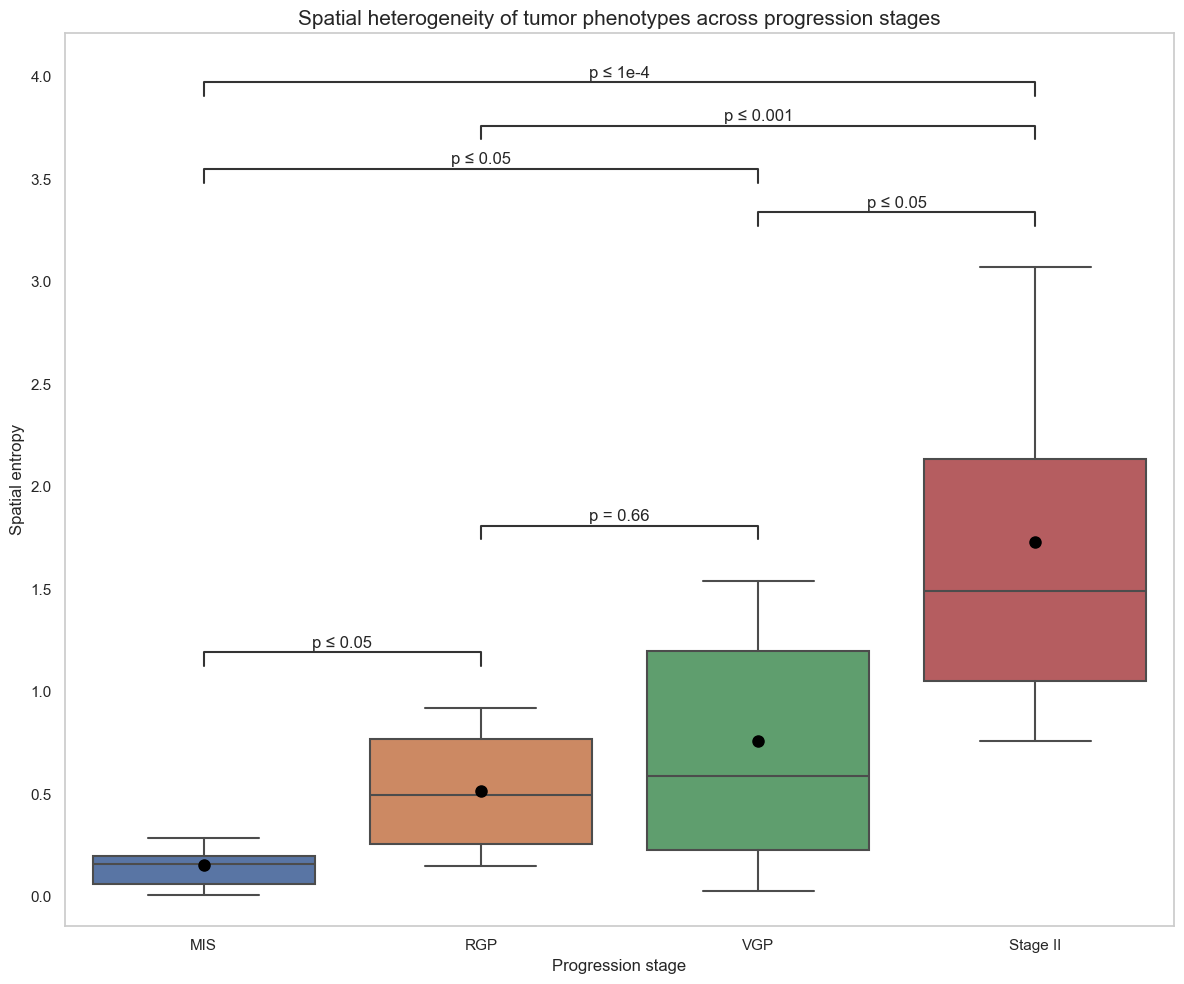

In [10]:
# Comparable VGP, RGP, MIS regions for graph analysis
adata_stage1 = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/reannotated_progression_ROIs/adata_e24_merged_splits_v4_09182023.h5ad')
adata_stage2 = scanpy.read_h5ad('/Users/ediknovik/Dropbox/Harvard-University/Sorger-HMS-Postdoc/PCA-Melanoma-Analysis/data/pca_stage2_samples/p135_e9_adtumorV5_TV.h5ad')

sample_dict_stage1 = {
               'VGP': ['LSP11411_lower_upper', 'LSP11411_upper', 'LSP11643_right_upper', 'LSP11355_lower_left', 'LSP11355_lower_right_right', 'LSP11355_upper', 'LSP11563_upper', 'LSP11595', 'LSP11747_upper'],
               'RGP': ['LSP11691_left', 'LSP11691_right', 'LSP11411_lower_upper', 'LSP11411_upper', 'LSP12422_left', 'LSP12422_right', 'LSP11315_right_upper', 'LSP11315_left_upper'],
               'MIS': ['LSP11523_upper', 'LSP11387_left_upper', 'LSP11387_right', 'LSP11347_lesion_b', 'LSP11347_lesion_a', 'LSP11691_left', 'LSP11691_right']
              }

heterogeneity_per_stage2_sample_with_stage1(adata_stage2, adata_stage1, sample_dict_stage1, node_attribute_name_stage2='simplified_phenotype', node_attribute_name_stage1='lineage_grouped', sample_column_name_stage2='contiguous_spatial')

Average number of neighbors per cell = 5.997112922002328
Average number of neighbors per cell = 5.9997343745849605
Average number of neighbors per cell = 5.999682302181867
Average number of neighbors per cell = 5.999737217262198
Average number of neighbors per cell = 5.9964717480413015
Average number of neighbors per cell = 5.998657042135303
Average number of neighbors per cell = 5.9976640971735575
Average number of neighbors per cell = 5.998485789718901
Average number of neighbors per cell = 5.998641324859226
Average number of neighbors per cell = 5.998918594172424
Average number of neighbors per cell = 5.999410192608976
Average number of neighbors per cell = 5.998530546269424
Average number of neighbors per cell = 5.9989697890643106
Average number of neighbors per cell = 5.995647873392681
Average number of neighbors per cell = 5.996288100506817
Average number of neighbors per cell = 5.999735292775318
Average number of neighbors per cell = 5.999545106301475
Average number of neighbors

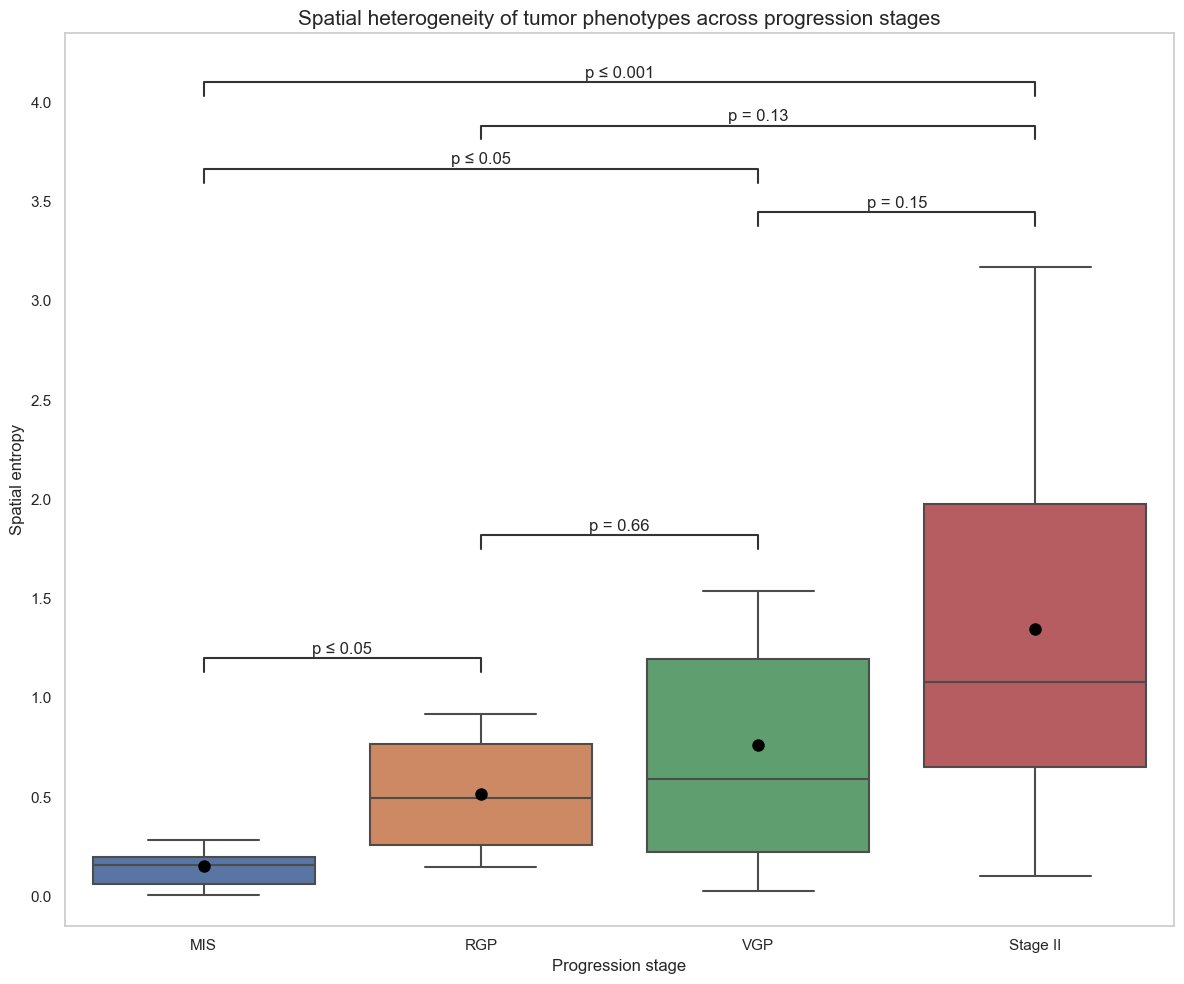

In [11]:
heterogeneity_per_stage2_sample_with_stage1(adata_stage2, adata_stage1, sample_dict_stage1, node_attribute_name_stage2='simplified_phenotype', node_attribute_name_stage1='lineage_grouped', sample_column_name_stage2='contiguous_spatial', include_ngfr_high=True)

In [11]:
pairs = [
            ('MIS', 'RGP'),
            ('RGP', 'VGP'),
            ('VGP', 'Stage II'),
            ('MIS', 'VGP'),
            ('MIS', 'Stage II'),
            ('RGP', 'Stage II')
        ]

MIS = stage1_and_2_df['MIS'].dropna().values
RGP = stage1_and_2_df['RGP'].dropna().values
VGP = stage1_and_2_df['VGP'].dropna().values
StageII = stage1_and_2_df['Stage II'].dropna().values

stat_results = [
                    mannwhitneyu(MIS, RGP, alternative="two-sided"),
                    mannwhitneyu(RGP, VGP, alternative="two-sided"),
                    mannwhitneyu(VGP, StageII, alternative="two-sided"),
                    mannwhitneyu(MIS, VGP, alternative="two-sided"),
                    mannwhitneyu(MIS, StageII, alternative="two-sided"),
                    mannwhitneyu(RGP, StageII, alternative="two-sided")
                ]
print("MIS vs RGP: ", stat_results[0])
print("RGP vs VGP: ", stat_results[1])
print("VGP vs Stage II: ", stat_results[2])
print("MIS vs VGP: ", stat_results[3])
print("MIS vs Stage II: ", stat_results[4])
print("RGP vs Stage II: ", stat_results[5])

pvalues = [result.pvalue for result in stat_results]
formatted_pvalues = [f"p={p:.2e}" for p in pvalues]

plotting_params = {
                        'data': stage1_and_2_df,
                        'showfliers': False,
                        'whis': 1,
                        'showmeans': True,
                        'meanprops': {'marker':'o',
                                      'markerfacecolor':'black', 
                                      'markeredgecolor':'black',
                                      'markersize':'8'}
                  }

MIS vs RGP:  MannwhitneyuResult(statistic=11.0, pvalue=0.012457614624797286)
RGP vs VGP:  MannwhitneyuResult(statistic=28.0, pvalue=0.6604718810601163)
VGP vs Stage II:  MannwhitneyuResult(statistic=21.0, pvalue=0.010439075899985918)
MIS vs VGP:  MannwhitneyuResult(statistic=28.0, pvalue=0.012728682084519901)
MIS vs Stage II:  MannwhitneyuResult(statistic=0.0, pvalue=3.897138871111154e-05)
RGP vs Stage II:  MannwhitneyuResult(statistic=2.0, pvalue=0.0006464124111182935)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MIS vs. RGP: p=1.25e-02
RGP vs. VGP: p=6.60e-01
VGP vs. Stage II: p=1.04e-02
MIS vs. VGP: p=1.27e-02
RGP vs. Stage II: p=6.46e-04
MIS vs. Stage II: p=3.90e-05


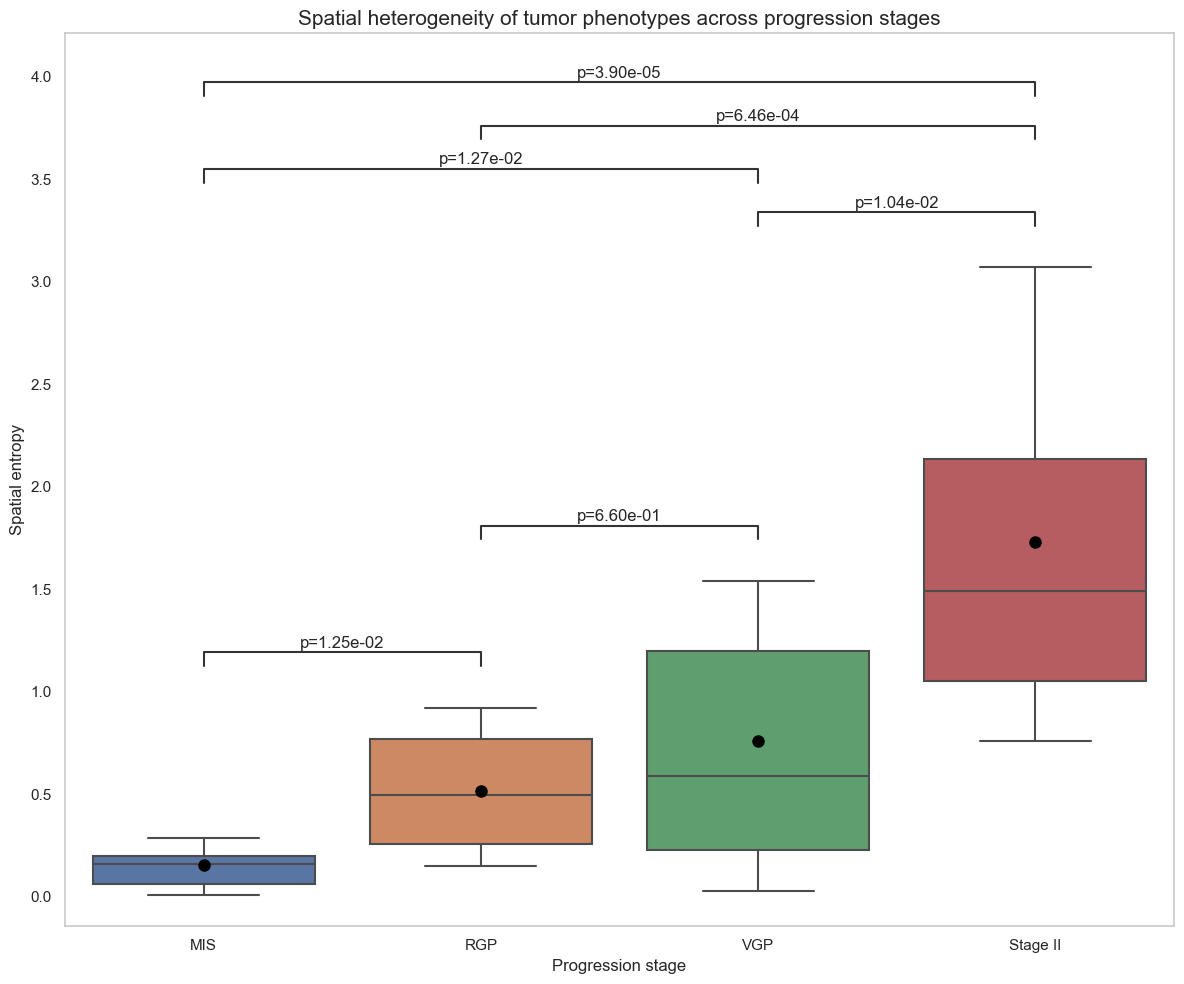

In [14]:
fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(**plotting_params)

# add statistical significance annotations
annotator = Annotator(ax, pairs, **plotting_params)
annotator.set_custom_annotations(formatted_pvalues)
annotator.annotate()

ax.set_title(f'Spatial heterogeneity of tumor phenotypes across progression stages', fontsize=15)
ax.set_xlabel('Progression stage')
ax.set_ylabel('Spatial entropy')
fig.tight_layout()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MIS vs. RGP: Custom statistical test, P_val:1.246e-02
RGP vs. VGP: Custom statistical test, P_val:6.605e-01
VGP vs. Stage II: Custom statistical test, P_val:1.044e-02
MIS vs. VGP: Custom statistical test, P_val:1.273e-02
RGP vs. Stage II: Custom statistical test, P_val:6.464e-04
MIS vs. Stage II: Custom statistical test, P_val:3.897e-05


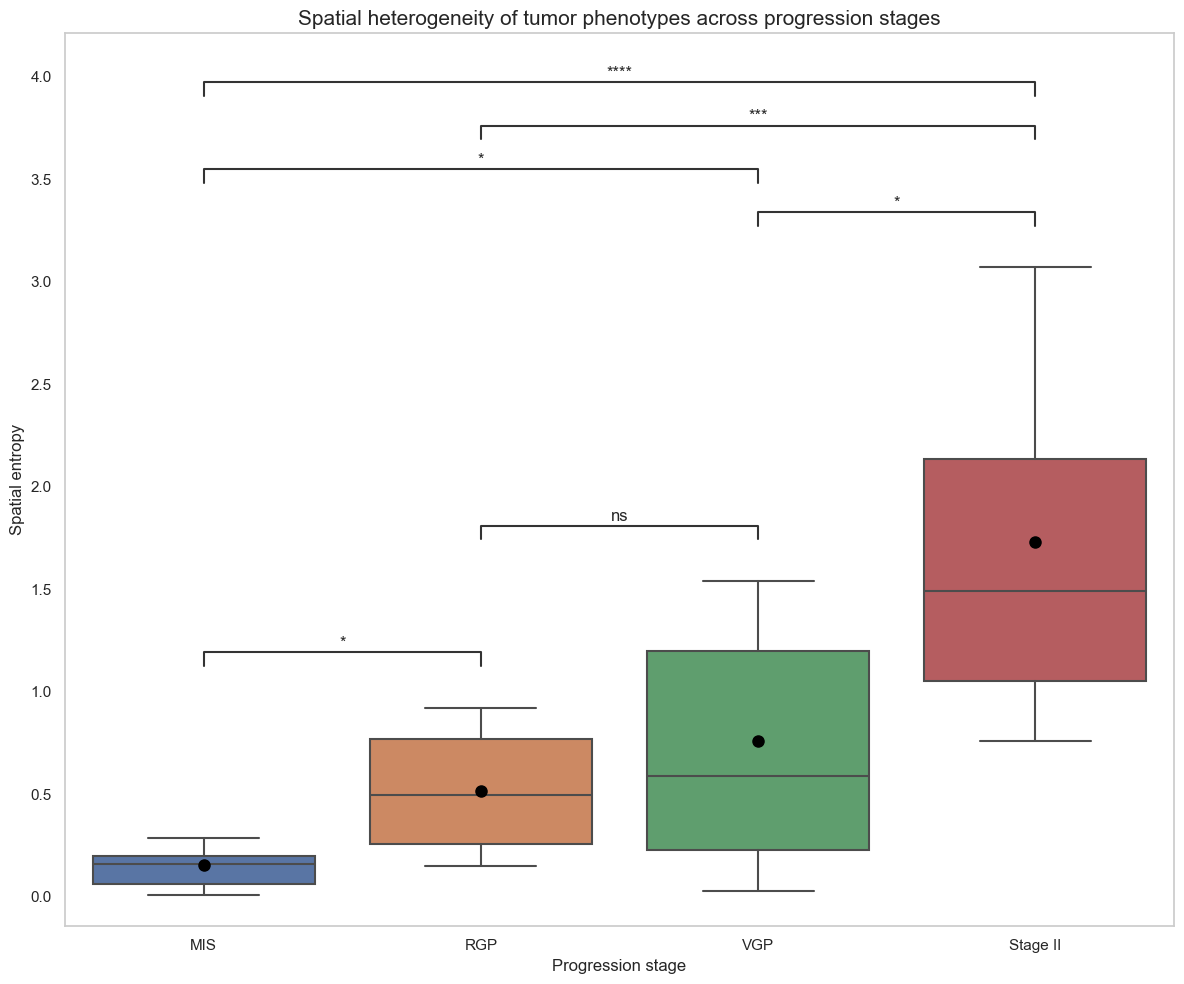

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(**plotting_params)

# add statistical significance annotations
annotator = Annotator(ax, pairs, **plotting_params)
annotator.set_pvalues(pvalues)
annotator.annotate()

ax.set_title(f'Spatial heterogeneity of tumor phenotypes across progression stages', fontsize=15)
ax.set_xlabel('Progression stage')
ax.set_ylabel('Spatial entropy')
fig.tight_layout()

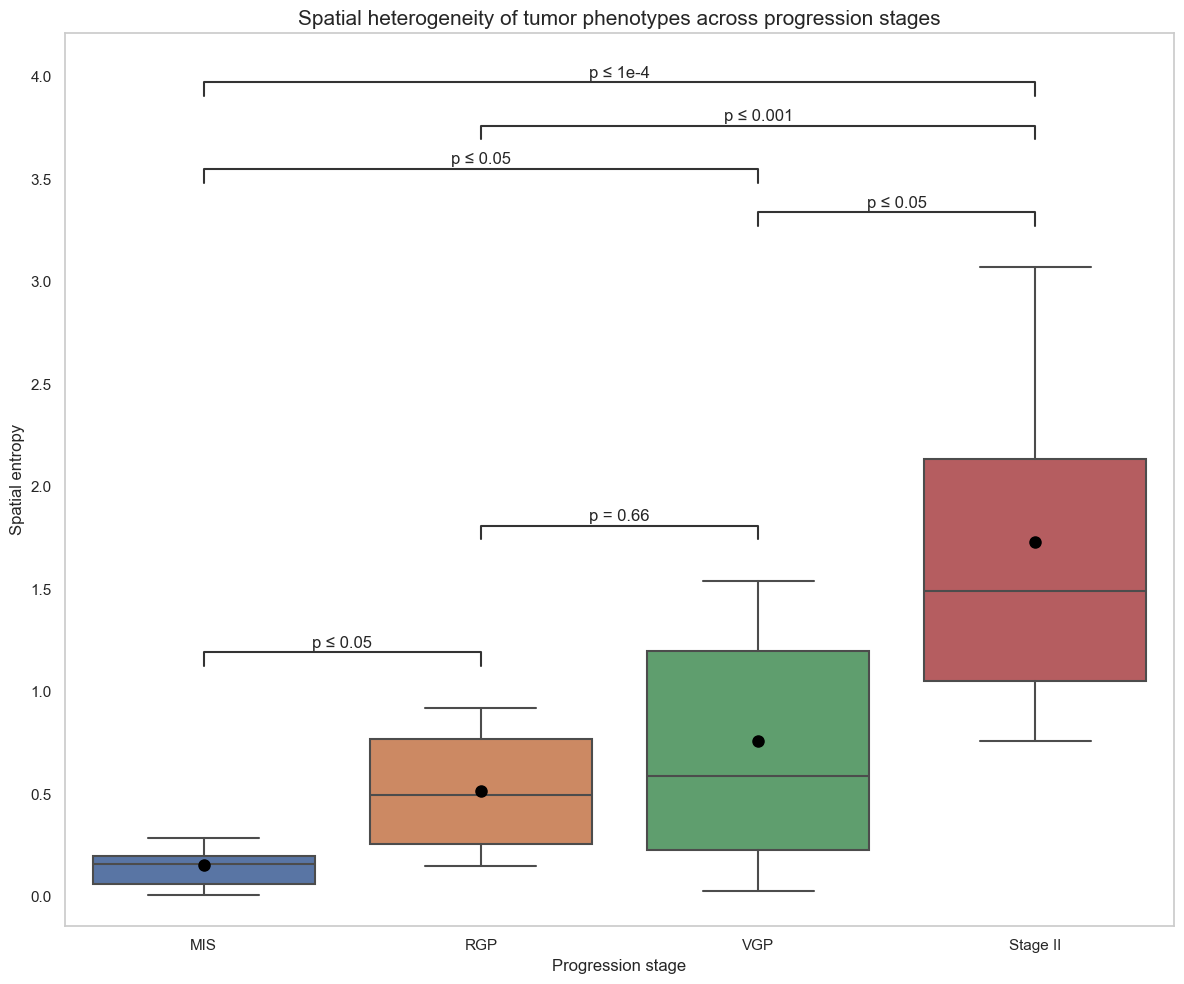

In [19]:
fig, ax = plt.subplots(figsize=(12,10))
sns.boxplot(**plotting_params)

# add statistical significance annotations
annotator = Annotator(ax, pairs, **plotting_params)
annotator.configure(text_format="simple", verbose=0)
annotator.set_pvalues(pvalues)
annotator.annotate()

ax.set_title(f'Spatial heterogeneity of tumor phenotypes across progression stages', fontsize=15)
ax.set_xlabel('Progression stage')
ax.set_ylabel('Spatial entropy')
fig.tight_layout()